In [80]:
import numpy             as np
import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
import pandas as pd

In [81]:
import pickle

def write_pkl(var,name_file):
    with open(f'variables_py\\{name_file}.pkl','wb') as arquivo:
        pickle.dump(var,arquivo)

def read_pkl(name_file):
    with open(f'variables_py\\{name_file}.pkl','rb') as arquivo:
        return pickle.load(arquivo)
    
def get_code_read_pkl(code_write_pkl):
    S = code_write_pkl.split("write_pkl(")[1]
    S = S.split("'")
    return S[0][:-1] + ' = read_pkl("' + S[1] + '")'

In [82]:
def plot2(series, legends=0,title=None):
    if legends==0:
        legends = ['' for _ in series]
    layout = go.Layout(height=1000,width=1500,title=title)
    fig = go.Figure(data=[go.Scatter(x=series[i].index, y=series[i].values, mode='lines', name=legends[i]) for i in range(len(series))], layout=layout)
    return fig

In [105]:
# N = 30
# Kw = 1
# phimax = 1
# phimin = 0
# beta = 0.5
# v_half = 7
# COM ISSO, phi(14.715) = 0.95
# entao v_0 = unif(0, 14.715)

In [83]:
r_seed = 1 # random seed

N = 30 # number of neurons
# N = 10 # number of neurons

t_sim = 100.0 # simulation time
# t_sim = 20.0 # simulation time

# alpha = 0.15
alpha = 1.0
# alpha = 1/0.02
# alpha = 5.0

t_ref       = 0.0   # refractory period in (ms)
V_reset     = 0.0   # reset membrane potential in (mV)

In [5]:
Kw = 1 # constant of increasing potential of chemical sinapses 
W = Kw * (np.ones((N,N)) - np.eye(N))
W.sum()

np.float64(870.0)

In [6]:
Wrandom = 2*np.random.random_sample((N,N))
Wrandom -= Wrandom*np.eye(N)
Wrandom.sum()

np.float64(880.4136653356)

np.float64(0.9500038925220798)

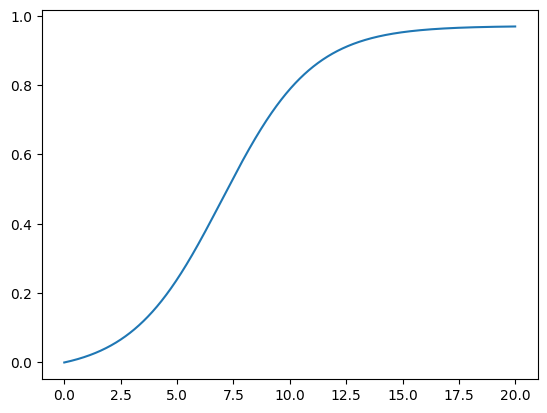

In [7]:

phi_min = 0.0 # 0.1
phi_max = 1 # 0.9
beta = 0.5
v_half = 7

def phi0(V, phi_min=phi_min, phi_max=phi_max, beta=beta, v_half=v_half):
    return phi_min + phi_max/(1+np.exp(-beta*(V-v_half)))

def phi(V, phi_min=phi_min, phi_max=phi_max, beta=beta, v_half=v_half):
    return phi0(V, phi_min, phi_max, beta, v_half) - phi0(0, phi_min, phi_max, beta, v_half)




x = np.arange(0,20,0.01)
y = phi(x)
plt.plot(x,y)

phi(14.715)


In [8]:
def phi_inf(V):
    a,b,v_half = [1.19, 27.0, -51.3+65]
    phi0 = np.exp((-v_half)/a)/b
    return np.exp((V-v_half)/a)/b-phi0

def max1(item):
    if item > 1: return 1
    return item

def phi_1(V):
    a,b,v_half = [1.19, 27.0, -51.3+65]
    return [max1(item) for item in np.exp((V-v_half)/a)/b]

def phi_ident(V):
    return V

x = np.arange(0,20,0.01)
y = phi(x)
# plt.plot(x,y)
y2 = phi_inf(x)
# plt.plot(x,y2)
y3 = phi_1(x)
# plt.plot(x,y3)
y4 = phi_ident(x)

plot2([pd.Series(y),pd.Series(y2),pd.Series(y3),pd.Series(y4)],['Phi','Phi inf','Phi 1','Phi Ident'])

In [10]:
phi_inf(0)

np.float64(0.0)

In [72]:
def run_simulation(W, reset_V=True, t_sim=t_sim, alpha=alpha, phi=phi, Vmax0=14.715, prints=False, Vmin0=0, V0=[]):
    #initial conditions
    phis = []
    times = []
    Vs = []

    if len(V0)!=N:
        if prints:
            print('V Start Random')
        V = np.random.uniform(Vmin0, Vmax0, size=N) 
    else:
        if prints:
            print('V start V0')
        V = V0

    phi_u = np.zeros(N)          #array to store phi values
    last_spike = np.zeros(N)

    # arrays to store spikes
    spk_t = [] # tempo do spike
    possible_spike_t = [] # tempo do possivel spike
    spk_id = [] # id do neuronio (0 a N-1) que teve o spike
    
    trun = 0.0

    times.append(trun)
    phis.append(phi_u)
    Vs.append(V)

    j = 0
    while (trun < t_sim):
        j+=1
        ALL=all(V<0.001)
        if ALL: 
            # print('MORREU EM', trun)
            # print('\nNumber of spikes per neuron: ' + str(len(spk_t)/N))
            return np.array(spk_t), np.array(spk_id), phis, times, Vs, trun, np.array(possible_spike_t)
        

        
        # compute phi(T-dt)
        # phi_u = phi(V, phi_min, phi_max, beta, v_half)
        phi_u = phi(V)
        S = np.sum(phi_u)
        if S == 0: 
            print('S==0')
            break

        dt = np.random.exponential(scale=1/S) # jogar exponencial de taxa soma(phi)
        
        V_old = V
        V = (V)*np.exp(-alpha*dt)
        #compute V(T)
        # phi em T
        # phi_u = phi(V, phi_min, phi_max, beta, v_half) 
        phi_u = phi(V) 

        # joga uniforme
        unif = np.random.uniform(low=0.0, high=S)
        S_new = np.sum(phi_u)
        trun += dt
        if prints:
            if j % 200 == 0:
                print()
                print('step ',j)
                print('Sum_phi ',S_new)
                print('t_run ',trun)
                print('V soma 1 ',sum(V_old))
                print('V soma 2 ',sum(V))

        times.append(trun)
        phis.append(phi_u)
        Vs.append(V)

        possible_spike_t.append(trun)

        if unif<=S_new:
            phi_cumsum = np.cumsum(phi_u)
            neuron_id = np.where(unif<=phi_cumsum)[0][0] # acha o neuronio tal que a uniforme caiu nele
            # print('SPIKE', neuron_id)

            # checking refractory period
            if last_spike[neuron_id]==0 or (trun-last_spike[neuron_id])>=t_ref:

                # updating of postsynaptic currents:
                V = V+W[neuron_id]
                last_spike[neuron_id] = trun
                # recording spike time and neuron index:
                spk_t.append(trun)
                spk_id.append(neuron_id)
                if reset_V:
                    V[neuron_id] = V_reset # Zera potencial


    # print('\nNumber of spikes per neuron: ' + str(len(spk_t)/N))
    # print('acabou a simulação')
    return np.array(spk_t), np.array(spk_id), phis, times, Vs, trun, np.array(possible_spike_t)

<!-- # 18/9 -> Teste se Exponencial => Power Laws -->

In [12]:
from scipy.stats import kstest, expon, shapiro, norm
def test_exponenciality(dados, confidence=0.95, Lambda=1):
    if pd.isnull(Lambda):
        loc, LambdaInv = expon.fit(dados)
        Lambda = 1/LambdaInv
        print(f'loc, Lambda = {loc},{Lambda}')
    statistic, p_value = kstest(dados, 'expon', args=(0, 1/Lambda))
    return [p_value, p_value > 1-confidence]

<!-- N = 30

Kw = 1

phimax = 1

phimin = 0

beta = 0.5

v_half = 7

COM ISSO, phi(14.715) = 0.95

entao v_0 = unif(0, 14.715) -->

In [21]:
# N = 300 # number of neurons
# Kw = 1 # constant of increasing potential of chemical sinapses 
# W = Kw * (np.ones((N,N)) - np.eye(N))
# W.sum()

In [118]:
# spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=1, alpha=10, phi=phi, Vmax0=14.715)
# spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=10000, alpha=10, phi=phi, Vmax0=14.715)
# print(trun)
# plt.plot([np.mean(item) for item in Vs])

In [13]:
def get_dfprob(dados,passo=None):
    if pd.isnull(passo):
        passo = (max(dados)-min(dados))/30
    bins = np.arange(min(dados), max(dados) + passo, passo)
    bins_discretizados = np.digitize(dados, bins)
    # Calculando a função de probabilidade P(X=x)
    valores_discretizados, contagem = np.unique(bins_discretizados, return_counts=True)
    probabilidade_empirica = contagem / len(dados)
    # Criando um DataFrame para organizar os resultados
    df_probabilidade = pd.DataFrame({
        'Bin': bins[valores_discretizados - 1],
        'P(X=x)': probabilidade_empirica
    })
    # Calculando a função de distribuição acumulada P(X>=x)
    df_probabilidade['P(X>=x)'] = df_probabilidade['P(X=x)'][::-1].cumsum()[::-1]
    return df_probabilidade, bins, valores_discretizados


def get_dfprob_log(dados,passo=None):
    log_dados = np.log(dados)
    if pd.isnull(passo):
        passo = (max(log_dados)-min(log_dados))/30

    bins = np.exp(np.arange(min(log_dados), max(log_dados) + passo, passo))
    
    bins_discretizados = np.digitize(dados, bins)
    # Calculando a função de probabilidade P(X=x)
    valores_discretizados, contagem = np.unique(bins_discretizados, return_counts=True)
    probabilidade_empirica = contagem / len(dados)
    # Criando um DataFrame para organizar os resultados
    df_probabilidade = pd.DataFrame({
        'Bin': bins[valores_discretizados - 1],
        'P(X=x)': probabilidade_empirica
    })
    # Calculando a função de distribuição acumulada P(X>=x)
    df_probabilidade['P(X>=x)'] = df_probabilidade['P(X=x)'][::-1].cumsum()[::-1]
    return df_probabilidade, bins, valores_discretizados




# GL

In [ ]:
sizes = []
durations = []
for ii in range(2000):
    # if ii % 50 == 0: print(ii)
    # spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=1, phi=phi, Vmax0=14.715)
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=1.4, phi=phi, Vmax0=14.715)
    durations.append(trun)
    sizes.append(len(spk_t))


In [ ]:
sizes2 = []
durations2 = []
for ii in range(2000):
    # if ii % 50 == 0: print(ii)
    # spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=0.97, phi=phi, Vmax0=14.715)
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=1.3, phi=phi, Vmax0=14.715)
    durations2.append(trun)
    sizes2.append(len(spk_t))


In [32]:
sizes3 = []
durations3 = []
# for ii in range(2000):
for ii in range(10000):
    # if ii % 50 == 0: print(ii)
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=3, phi=phi, Vmax0=14.715)
    durations3.append(trun)
    sizes3.append(len(spk_t))


In [16]:
sizes4 = []
durations4 = []
for ii in range(2000):
    # if ii % 50 == 0: print(ii)
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=1.5, phi=phi, Vmax0=14.715)
    durations4.append(trun)
    sizes4.append(len(spk_t))


In [15]:
sizes11 = []
durations11 = []
for ii in range(2000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=1.1, phi=phi, Vmax0=14.715)
    durations11.append(trun)
    sizes11.append(len(spk_t))

sizes12 = []
durations12 = []
for ii in range(2000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=1.2, phi=phi, Vmax0=14.715)
    durations12.append(trun)
    sizes12.append(len(spk_t))

sizes13 = []
durations13 = []
for ii in range(2000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=1.3, phi=phi, Vmax0=14.715)
    durations13.append(trun)
    sizes13.append(len(spk_t))

sizes14 = []
durations14 = []
for ii in range(2000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=1.4, phi=phi, Vmax0=14.715)
    durations14.append(trun)
    sizes14.append(len(spk_t))

sizes15 = []
durations15 = []
for ii in range(2000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=1.5, phi=phi, Vmax0=14.715)
    durations15.append(trun)
    sizes15.append(len(spk_t))

sizes16 = []
durations16 = []
for ii in range(2000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=1.6, phi=phi, Vmax0=14.715)
    durations16.append(trun)
    sizes16.append(len(spk_t))

sizes2 = []
durations2 = []
for ii in range(2000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=2, phi=phi, Vmax0=14.715)
    durations2.append(trun)
    sizes2.append(len(spk_t))


In [16]:
# sizes25 = []
# durations25 = []
# for ii in range(2000):
    # spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=2.5, phi=phi, Vmax0=14.715)
    # durations25.append(trun)
    # sizes25.append(len(spk_t))

sizes3 = []
durations3 = []
for ii in range(2000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=5, phi=phi, Vmax0=14.715)
    durations3.append(trun)
    sizes3.append(len(spk_t))

In [17]:
[sizes1,durations1,sizes097,durations097] = read_pkl('Sizes_Durations_2000Trials_WUnif_alpha1_and_alpha097_phi_Vmax0_14p715')

In [18]:
import powerlaw

In [77]:
sizes11 = []
durations11 = []
for ii in range(2000):
    spk_t, spk_id, phis, times, Vs, trun, poss_spk_t = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=2, phi=phi, Vmax0=14.715)
    durations11.append(trun)
    sizes11.append(len(poss_spk_t))


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


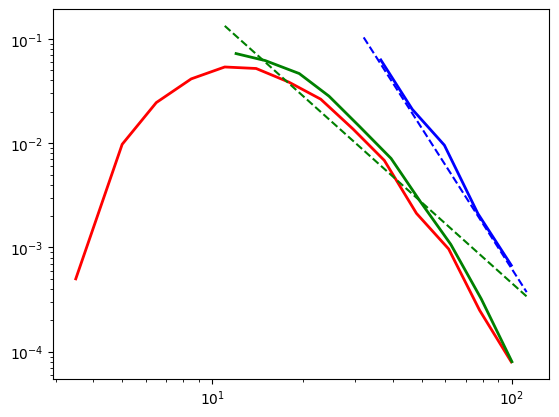


power_law
4.815958610001509e-28
145.94908814252085


lognormal
0.16474582050140274
-4.1292738374714375


exponential
1.0
0.0


truncated_power_law


Assuming nested distributions


0.0004083341497652188
18.07775946226427


stretched_exponential
0.6088083007896548
-0.1309569628984799


lognormal_positive
0.16474582050140274
-4.1292738374714375



Assuming nested distributions


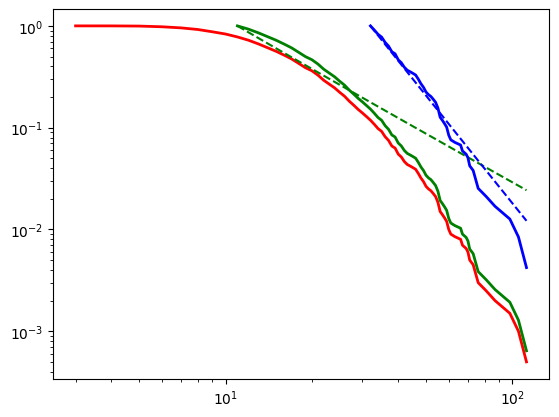

In [79]:

# dados = [1+item for item in durations3]
# discrete=False

dados = [item for item in sizes11 if item>0]
discrete=True

dados = np.sort(dados)
parameter_range = {'xmin': [None, dados[len(dados)//3]]}

fit_rest = powerlaw.Fit(dados,discrete=discrete, parameter_range=parameter_range)
fit_free = powerlaw.Fit(dados,discrete=discrete)
# print(fit.xmin)
# print(dados[len(dados)//2])
fig2 = fit_free.plot_pdf(color='r', linewidth=2,original_data=True)
fit_rest.plot_pdf(color='g', linewidth=2,original_data=False)
fit_rest.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)
fit_free.plot_pdf(color='b', linewidth=2,original_data=False)
fit_free.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
plt.show()

fig3 = fit_free.plot_ccdf(color='r', linewidth=2,original_data=True)
fit_rest.plot_ccdf(color='g', linewidth=2,original_data=False)
fit_rest.power_law.plot_ccdf(color='g', linestyle='--', ax=fig3)
fit_free.plot_ccdf(color='b', linewidth=2,original_data=False)
fit_free.power_law.plot_ccdf(color='b', linestyle='--', ax=fig3)

# fit_free.distribution_compare('exponential','power_law'),fit_rest.distribution_compare('exponential','power_law'),fit_rest.distribution_compare('lognormal','exponential')
# fit_free.distribution_compare('exponential','power_law'),fit_rest.distribution_compare('exponential','power_law'),fit_rest.distribution_compare('lognormal','exponential')
for dist in fit_free.supported_distributions.keys():
    print()
    print(dist)
    R,p = fit_rest.distribution_compare('exponential',dist)
    print(p)
    print(R)
    print()





Calculating best minimal value for power law fit


<Axes: >

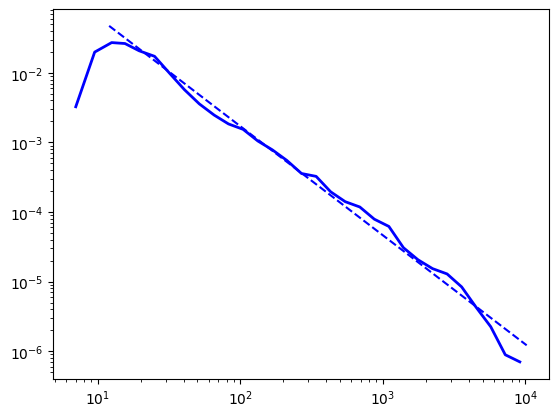

In [31]:

dados = durations14

fit = powerlaw.Fit(dados)
fig2 = fit.plot_pdf(color='b', linewidth=2,original_data=True)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)

In [16]:
from scipy.interpolate import CubicSpline

def get_density(x_grid, dados):
    # dados = sizes3/np.mean(sizes3)
    knots = np.linspace(min(dados), max(dados), 20)  # 10 nós uniformemente espaçados
    hist, edges = np.histogram(dados, bins=knots, density=True)
    centros = (edges[:-1] + edges[1:]) / 2
    log_densidades = np.log(hist + 1e-9)  # Adiciona um pequeno valor para evitar log(0)
    spline = CubicSpline(centros, log_densidades, bc_type='natural')
    # x_grid = np.linspace(0, 8, 1000)
    densidade_estimada = np.exp(spline(x_grid))
    return densidade_estimada

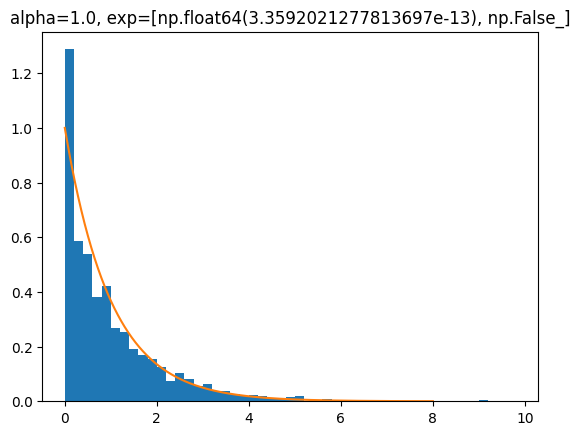

In [17]:
# dados = np.array(durations)/np.mean(durations)
# dados = np.array(sizes)/np.mean(sizes)
# alpha = 1.4

# dados = np.array(durations2)/np.mean(durations2)
# dados = np.array(sizes2)/np.mean(sizes2)
# alpha = 0.97

# dados = np.array(durations3)/np.mean(durations3)
# dados = np.array(durations3)/np.mean(durations3)
# dados = np.array(sizes3)/np.mean(sizes3)
dados = np.array(sizes12)/np.mean(sizes12)
# alpha = 3

# dados = np.array(durations4)/np.mean(durations4)
# dados = np.array(sizes4)/np.mean(sizes4)
# alpha = 1.2
x_grid = np.linspace(0, 8, 1000)



plt.title(f'alpha={alpha}, exp={test_exponenciality(dados)}')

# plt.hist(dados, bins=[item/5 for item in range(15*10)], density=True)
# plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
plt.hist(dados, bins=[item/5 for item in range(5*10)], density=True)
plt.plot(x_grid, np.exp(-x_grid))
# plt.plot(x_grid[30:], 1/(-x_grid[30:])**10)
# plt.plot(x_grid, get_density(x_grid, dados))
plt.show()

In [21]:
# write_pkl([sizes,durations,sizes2,durations2],'Sizes_Durations_2000Trials_WUnif_alpha1_and_alpha097_phi_Vmax0_14p715')

In [19]:
pip install powerlaw

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import powerlaw

In [21]:
# def test_exponenciality(dados, confidence=0.95, Lambda=1):
    # if pd.isnull(Lambda):
        # loc, LambdaInv = expon.fit(dados)
        # Lambda = 1/LambdaInv
        # print(f'loc, Lambda = {loc},{Lambda}')
statistic, p_value = kstest(sizes12, 'powerlaw', args=(1,))
p_value
    # return [p_value, p_value > 1-confidence]

np.float64(0.0)

In [193]:
def generate_power_law(alpha, xmin, size):
    r = np.random.uniform(0, 1, size)
    return xmin * (1 - r) ** (-1 / (alpha - 1))

dados = generate_power_law(3, 0.1, 1000)

In [84]:
dados =[item+1 for item in sizes12]

In [81]:
dados = np.random.pareto(3,1000)

In [40]:
import scipy.stats as stats

Calculating best minimal value for power law fit
2000 progress: 99%
2000 1
Estatística KS: 0.9922025083873578
p-valor: 0.0


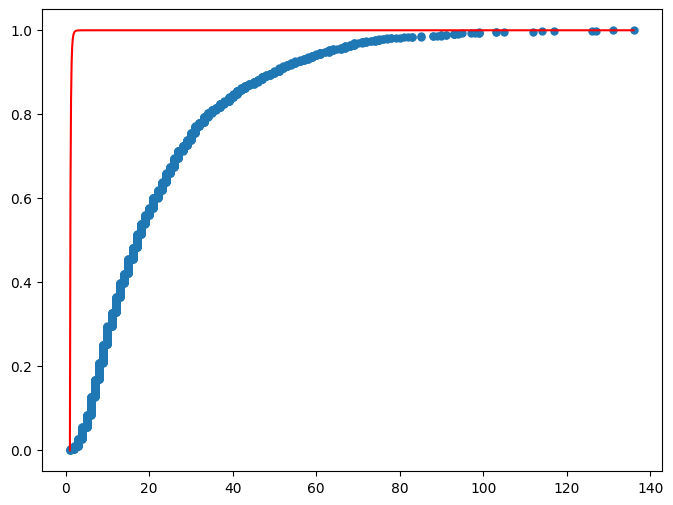

In [279]:
fit = powerlaw.Fit(dados)
alpha = fit.power_law.alpha

def power_law_cdf(x, alpha, xmin):
    cdf = 1 - (xmin / x) ** (alpha - 1)
    return cdf

# 1. Gerar dados distribuídos segundo uma Power Law com alpha conhecido
xmin = min(dados)
# xmin = 
# size = 1000
# data = xmin * (1 - np.random.rand(size)) ** (-1 / (alpha - 1))

print(len(dados))

print(len(dados), min(dados))
# 2. Função acumulada empírica (CDF empírica)
data_sorted = np.sort(dados)
cdf_empirical = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

# 3. Teste de Kolmogorov-Smirnov para comparar a CDF empírica com a CDF teórica
D, p_value = stats.kstest(data_sorted, lambda x: power_law_cdf(x, alpha, xmin))

print(f"Estatística KS: {D}")
print(f"p-valor: {p_value}")


x_vals = np.linspace(xmin, max(data_sorted), 1000)
cdf_theoretical = power_law_cdf(x_vals, alpha, xmin)

plt.figure(figsize=(8, 6))
plt.plot(data_sorted, cdf_empirical, label="CDF Empírica", marker="o", linestyle="none", markersize=5)
plt.plot(x_vals, cdf_theoretical, label=f"CDF Teórica (Power Law, alpha={alpha})", color="red")

10000


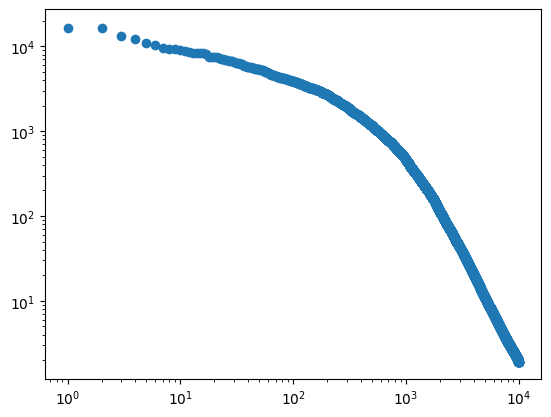

In [270]:
# dados =[item+1 for item in sizes3]
# dados =[item+1 for item in sizesHK3]
# dados =[item for item in durationsHK3]
# dados =[item+0.1 for item in durations2]
# dados =[item+0.1 for item in durationsHK5]
# dados =[item for item in durationsHK5]
print(len(dados))
dados = list(dados)
dados.sort(reverse=True)
dados = dados[:]
plt.loglog(dados, marker='o', linestyle='none')

2000


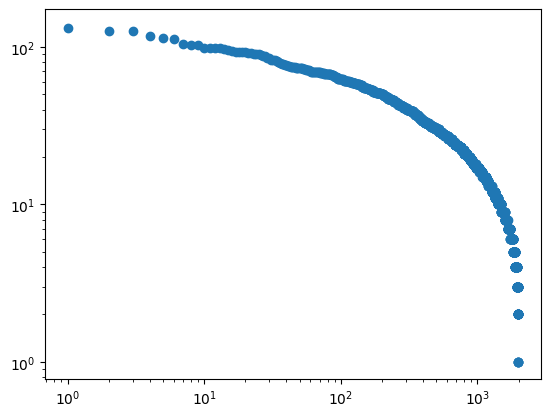

In [278]:
dados =[item+1 for item in sizes16]
print(len(dados))
dados = list(dados)
dados.sort(reverse=True)
dados = dados[:]
plt.loglog(dados, marker='o', linestyle='none')

In [220]:

print(alpha)

stats.powerlaw.pdf

# R, p_value = fit.distribution_compare('power_law', 'lognormal')
# R, p_value, alpha

statistic, p_value = kstest(dados, 'powerlaw', args=(alpha,0.1))
p_value

3.5238734102156566


np.float64(0.0)

In [79]:
# df_probabilidade, bins, valores_discretizados = get_dfprob([item+1 for item in sizes14])
# plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')
# plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')

# df_probabilidade, bins, valores_discretizados = get_dfprob_log([item+1 for item in sizes14])
# plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')
# plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')

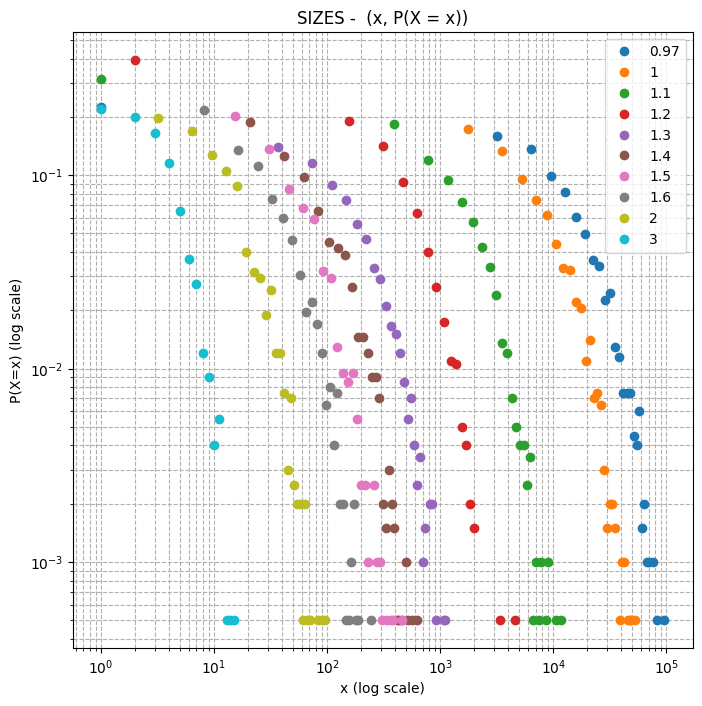

In [65]:
legend = []
series = []
plt.figure(figsize=(8, 8))
# fig, ax = plt.subplots(figsize=(8, 6))
# for dados, alpha in [[sizes097,0.97], [sizes1,1],[sizes11,1.1],[sizes12,1.2],[sizes13,1.3],[sizes14,1.4],[sizes15,1.5],[sizes16,1.6],[sizes2,2],[sizes25,2.5],[sizes3,3]]:
for dados, alpha in [[sizes097,0.97], [sizes1,1],[sizes11,1.1],[sizes12,1.2],[sizes13,1.3],[sizes14,1.4],[sizes15,1.5],[sizes16,1.6],[sizes2,2],[sizes3,3]]:
    legend.append(str(alpha))
    df_probabilidade, bins, valores_discretizados = get_dfprob(dados)
    plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
    # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')


plt.title('SIZES -  (x, P(X = x))')
plt.ylabel('P(X=x) (log scale)')
plt.legend(legend)
plt.xlabel('x (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()


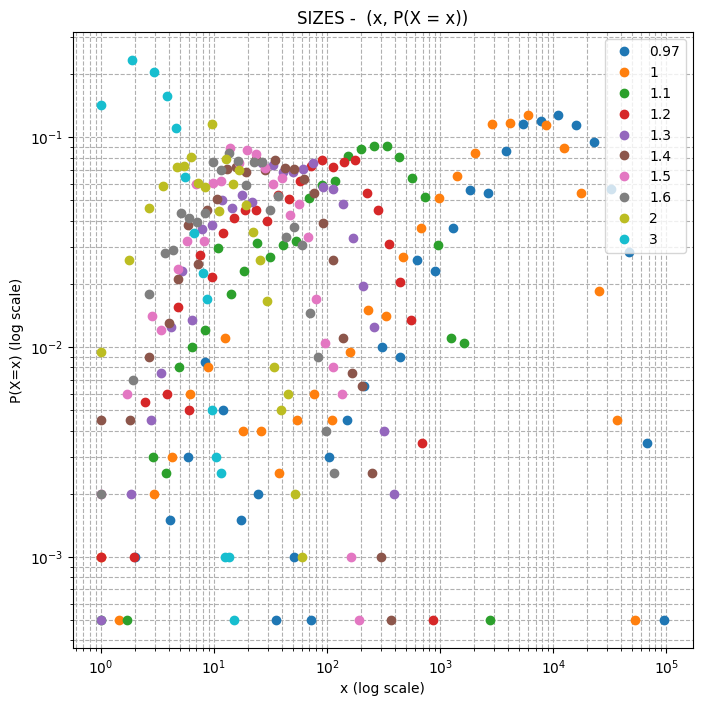

In [283]:
legend = []
series = []
plt.figure(figsize=(8, 8))
# fig, ax = plt.subplots(figsize=(8, 6))
# for dados, alpha in [[sizes097,0.97], [sizes1,1],[sizes11,1.1],[sizes12,1.2],[sizes13,1.3],[sizes14,1.4],[sizes15,1.5],[sizes16,1.6],[sizes2,2],[sizes25,2.5],[sizes3,3]]:
for dados, alpha in [[sizes097,0.97], [sizes1,1],[sizes11,1.1],[sizes12,1.2],[sizes13,1.3],[sizes14,1.4],[sizes15,1.5],[sizes16,1.6],[sizes2,2],[sizes3,3]]:
# for dados, alpha in [[sizes097,0.97], [sizes1,1],[sizes11,1.1],[sizes12,1.2],[sizes13,1.3]]:
# for dados, alpha in [[sizes14,1.4],[sizes15,1.5],[sizes16,1.6],[sizes2,2],[sizes25,2.5],[sizes3,3]]:
    legend.append(str(alpha))
    df_probabilidade, bins, valores_discretizados = get_dfprob_log([item+1 for item in dados])
    plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
    # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')


plt.title('SIZES -  (x, P(X = x))')
plt.ylabel('P(X=x) (log scale)')
plt.legend(legend)
plt.xlabel('x (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()

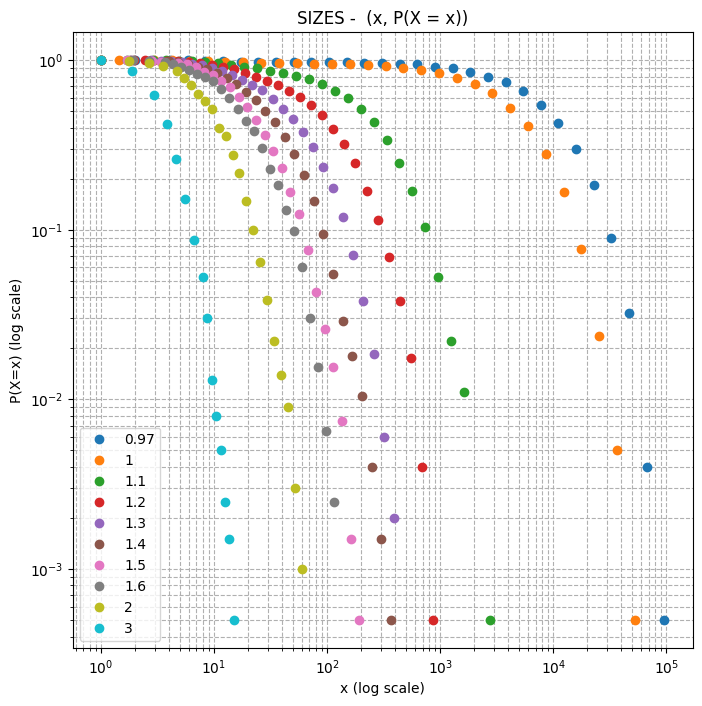

In [284]:
legend = []
series = []
plt.figure(figsize=(8, 8))
# fig, ax = plt.subplots(figsize=(8, 6))
# for dados, alpha in [[sizes097,0.97], [sizes1,1],[sizes11,1.1],[sizes12,1.2],[sizes13,1.3],[sizes14,1.4],[sizes15,1.5],[sizes16,1.6],[sizes2,2],[sizes25,2.5],[sizes3,3]]:
for dados, alpha in [[sizes097,0.97], [sizes1,1],[sizes11,1.1],[sizes12,1.2],[sizes13,1.3],[sizes14,1.4],[sizes15,1.5],[sizes16,1.6],[sizes2,2],[sizes3,3]]:
# for dados, alpha in [[sizes097,0.97], [sizes1,1],[sizes11,1.1],[sizes12,1.2],[sizes13,1.3]]:
# for dados, alpha in [[sizes14,1.4],[sizes15,1.5],[sizes16,1.6],[sizes2,2],[sizes25,2.5],[sizes3,3]]:
    legend.append(str(alpha))
    df_probabilidade, bins, valores_discretizados = get_dfprob_log([item+1 for item in dados])
    # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
    plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')


plt.title('SIZES -  (x, P(X = x))')
plt.ylabel('P(X=x) (log scale)')
plt.legend(legend)
plt.xlabel('x (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()

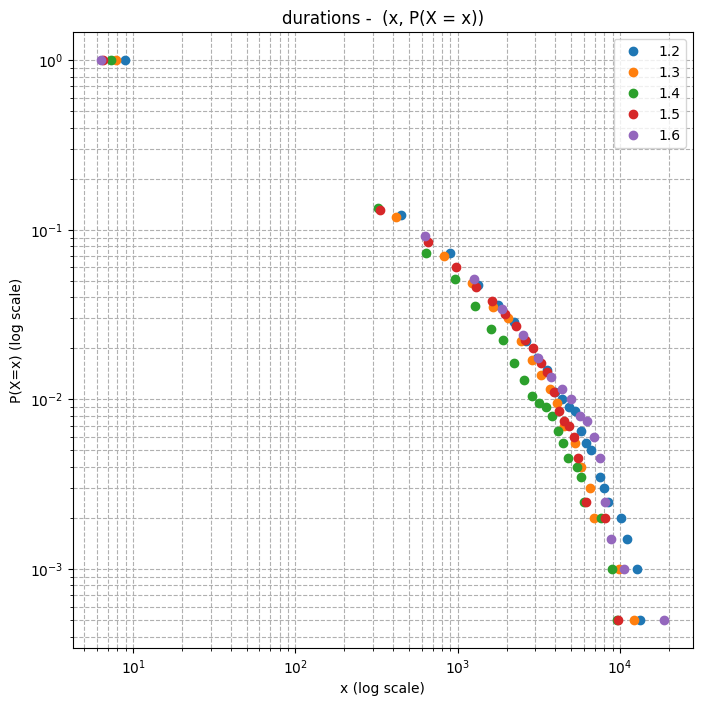

In [143]:
legend = []
series = []
plt.figure(figsize=(8, 8))
# for dados, alpha in [[durations097,0.97], [durations1,1],[durations11,1.1],[durations12,1.2],[durations13,1.3],[durations14,1.4],[durations15,1.5],[durations16,1.6],[durations2,2],[durations25,2.5],[durations3,3]]:
# for dados, alpha in [[durations097,0.97], [durations1,1],[durations11,1.1]]:
for dados, alpha in [[durations12,1.2],[durations13,1.3],[durations14,1.4],[durations15,1.5],[durations16,1.6]]:
# for dados, alpha in [[durations16,1.6],[durations2,2],[durations25,2.5],[durations3,3]]:
    legend.append(str(alpha))
    df_probabilidade, bins, valores_discretizados = get_dfprob(dados)
    # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
    plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')


plt.title('durations -  (x, P(X = x))')
plt.ylabel('P(X=x) (log scale)')
plt.legend(legend)
plt.xlabel('x (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()


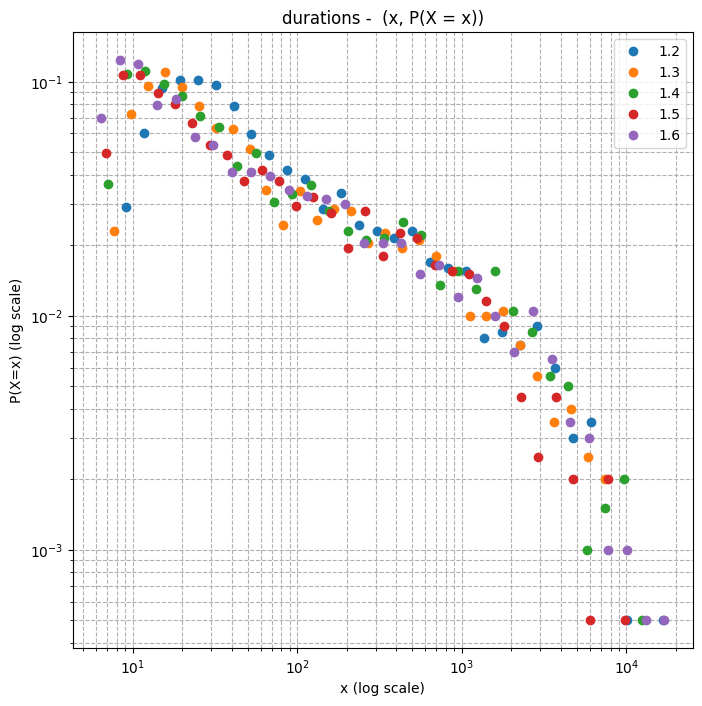

In [292]:
legend = []
series = []
plt.figure(figsize=(8, 8))
# for dados, alpha in [[durations097,0.97], [durations1,1],[durations11,1.1],[durations12,1.2],[durations13,1.3],[durations14,1.4],[durations15,1.5],[durations16,1.6],[durations2,2],[durations25,2.5],[durations3,3]]:
# for dados, alpha in [[durations097,0.97], [durations1,1],[durations11,1.1]]:
for dados, alpha in [[durations12,1.2],[durations13,1.3],[durations14,1.4],[durations15,1.5],[durations16,1.6]]:
# for dados, alpha in [[durations16,1.6],[durations2,2],[durations25,2.5],[durations3,3]]:
    legend.append(str(alpha))
    df_probabilidade, bins, valores_discretizados = get_dfprob_log(dados)
    plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
    # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')


plt.title('durations -  (x, P(X = x))')
plt.ylabel('P(X=x) (log scale)')
plt.legend(legend)
plt.xlabel('x (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()

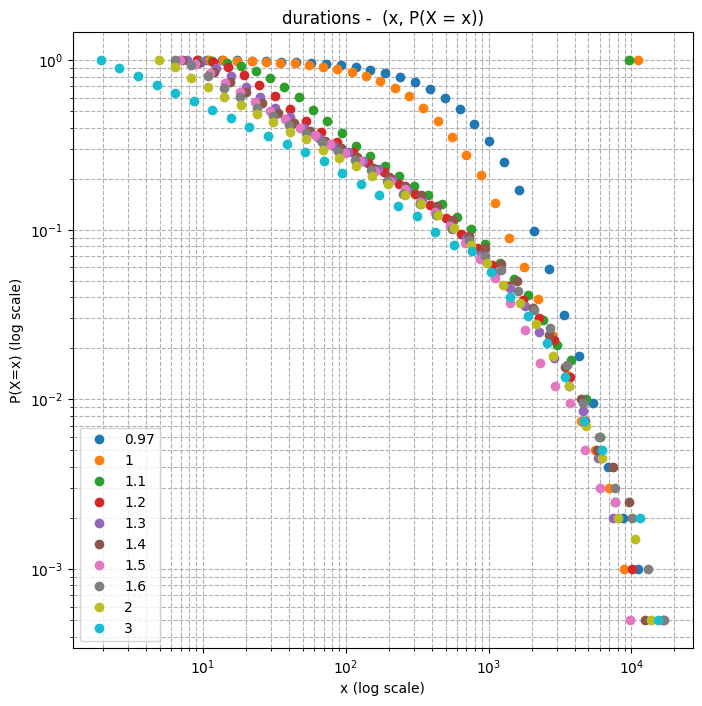

In [291]:
legend = []
series = []
plt.figure(figsize=(8, 8))
# for dados, alpha in [[durations097,0.97], [durations1,1],[durations11,1.1],[durations12,1.2],[durations13,1.3],[durations14,1.4],[durations15,1.5],[durations16,1.6],[durations2,2],[durations25,2.5],[durations3,3]]:
for dados, alpha in [[durations097,0.97], [durations1,1],[durations11,1.1],[durations12,1.2],[durations13,1.3],[durations14,1.4],[durations15,1.5],[durations16,1.6],[durations2,2],[durations3,3]]:
# for dados, alpha in [[durations097,0.97], [durations1,1],[durations11,1.1]]:
# for dados, alpha in [[durations12,1.2],[durations13,1.3],[durations14,1.4],[durations15,1.5],[durations16,1.6]]:
# for dados, alpha in [[durations16,1.6],[durations2,2],[durations25,2.5],[durations3,3]]:
    legend.append(str(alpha))
    df_probabilidade, bins, valores_discretizados = get_dfprob_log(dados)
    # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
    plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')


plt.title('durations -  (x, P(X = x))')
plt.ylabel('P(X=x) (log scale)')
plt.legend(legend)
plt.xlabel('x (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()

# HK

In [15]:
# sizesHK16 = []
# durationsHK16 = []
# for ii in range(30):
#     spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=False, t_sim=np.inf, alpha=1.7, phi=phi, Vmax0=14.715)
#     durationsHK16.append(trun)
#     sizesHK16.append(len(spk_t))

In [66]:

# sizesHK11 = []
# durationsHK11 = []
# for ii in range(300):
#     spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=False, t_sim=np.inf, alpha=1.1, phi=phi, Vmax0=14.715)
#     durationsHK11.append(trun)
#     sizesHK11.append(len(spk_t))

# sizesHK12 = []
# durationsHK12 = []
# for ii in range(2000):
#     spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=False, t_sim=np.inf, alpha=1.2, phi=phi, Vmax0=14.715)
#     durationsHK12.append(trun)
#     sizesHK12.append(len(spk_t))

# sizesHK13 = []
# durationsHK13 = []
# for ii in range(2000):
#     spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=False, t_sim=np.inf, alpha=1.3, phi=phi, Vmax0=14.715)
#     durationsHK13.append(trun)
#     sizesHK13.append(len(spk_t))

# sizesHK14 = []
# durationsHK14 = []
# for ii in range(2000):
#     spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=False, t_sim=np.inf, alpha=1.4, phi=phi, Vmax0=14.715)
#     durationsHK14.append(trun)
#     sizesHK14.append(len(spk_t))

# sizesHK15 = []
# durationsHK15 = []
# for ii in range(2000):
#     spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=False, t_sim=np.inf, alpha=1.5, phi=phi, Vmax0=14.715)
#     durationsHK15.append(trun)
#     sizesHK15.append(len(spk_t))

# sizesHK16 = []
# durationsHK16 = []
# for ii in range(300):
#     spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=False, t_sim=np.inf, alpha=1.6, phi=phi, Vmax0=14.715)
#     durationsHK16.append(trun)
#     sizesHK16.append(len(spk_t))

sizesHK17 = []
durationsHK17 = []
for ii in range(1000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=False, t_sim=np.inf, alpha=1.7, phi=phi, Vmax0=14.715)
    durationsHK17.append(trun)
    sizesHK17.append(len(spk_t))

sizesHK18 = []
durationsHK18 = []
for ii in range(1000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=False, t_sim=np.inf, alpha=1.8, phi=phi, Vmax0=14.715)
    durationsHK18.append(trun)
    sizesHK18.append(len(spk_t))

sizesHK2 = []
durationsHK2 = []
for ii in range(1000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=False, t_sim=np.inf, alpha=2, phi=phi, Vmax0=14.715)
    durationsHK2.append(trun)
    sizesHK2.append(len(spk_t))

sizesHK25 = []
durationsHK25 = []
for ii in range(1000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=False, t_sim=np.inf, alpha=2.5, phi=phi, Vmax0=14.715)
    durationsHK25.append(trun)
    sizesHK25.append(len(spk_t))

sizesHK3 = []
durationsHK3 = []
for ii in range(1000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=False, t_sim=np.inf, alpha=3, phi=phi, Vmax0=14.715)
    durationsHK3.append(trun)
    sizesHK3.append(len(spk_t))


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


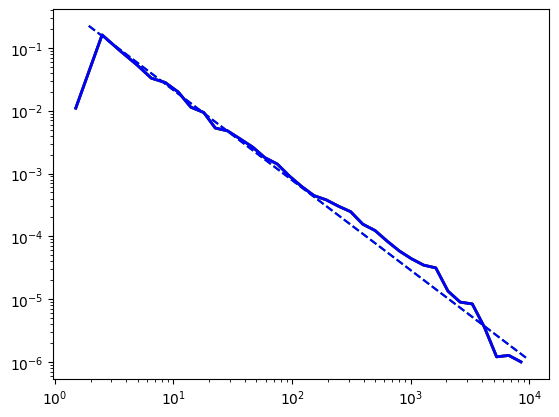


power_law
1.2030415224882266e-129
-3036.8752019097515


lognormal
5.737762830060735e-141
-3065.1960530581864


exponential
1.0
0.0


truncated_power_law


Assuming nested distributions


3.0747027557729826e-146
-3099.1023906950522


stretched_exponential
0.0
-3070.294810919304


lognormal_positive
4.771752495976029e-148
-3048.911070618104



Assuming nested distributions


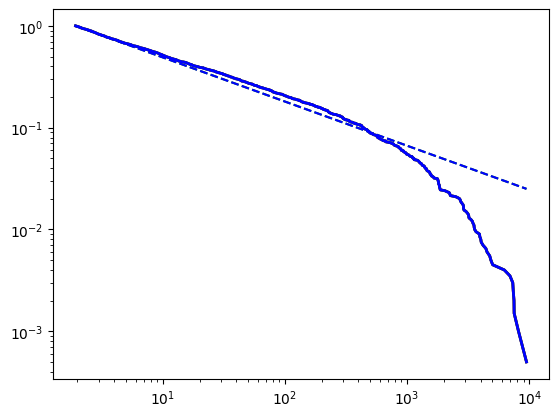

In [70]:

dados = [item for item in durations3]
discrete=False

# dados = [item for item in sizesHK3 if item>0]
# discrete=True

dados = np.sort(dados)
parameter_range = {'xmin': [None, dados[len(dados)//2]]}

fit_rest = powerlaw.Fit(dados,discrete=discrete, parameter_range=parameter_range)
fit_free = powerlaw.Fit(dados,discrete=discrete)
# print(fit.xmin)
# print(dados[len(dados)//2])
fig2 = fit_free.plot_pdf(color='r', linewidth=2,original_data=True)
fit_rest.plot_pdf(color='g', linewidth=2,original_data=False)
fit_rest.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)
fit_free.plot_pdf(color='b', linewidth=2,original_data=False)
fit_free.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
plt.show()

fig3 = fit_free.plot_ccdf(color='r', linewidth=2,original_data=True)
fit_rest.plot_ccdf(color='g', linewidth=2,original_data=False)
fit_rest.power_law.plot_ccdf(color='g', linestyle='--', ax=fig3)
fit_free.plot_ccdf(color='b', linewidth=2,original_data=False)
fit_free.power_law.plot_ccdf(color='b', linestyle='--', ax=fig3)

# fit_free.distribution_compare('exponential','power_law'),fit_rest.distribution_compare('exponential','power_law'),fit_rest.distribution_compare('lognormal','exponential')
# fit_free.distribution_compare('exponential','power_law'),fit_rest.distribution_compare('exponential','power_law'),fit_rest.distribution_compare('lognormal','exponential')
for dist in fit_free.supported_distributions.keys():
    print()
    print(dist)
    R,p = fit_rest.distribution_compare('exponential',dist)
    print(p)
    print(R)
    print()





In [260]:
W.sum().sum()

np.float64(870.0)

In [261]:
def erdos_reny(n, p=0.8, k=1):
    adj_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if np.random.rand() < p: 
                adj_matrix[i, j] = k
            
    return adj_matrix

W = erdos_reny(30, 0.8, 1.2)
W.sum().sum()

np.float64(847.1999999999998)

In [262]:
sizesHK5 = []
durationsHK5 = []
for ii in range(10000):
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=False, t_sim=np.inf, alpha=5, phi=phi, Vmax0=14.715)
    durationsHK5.append(trun)
    sizesHK5.append(len(spk_t))

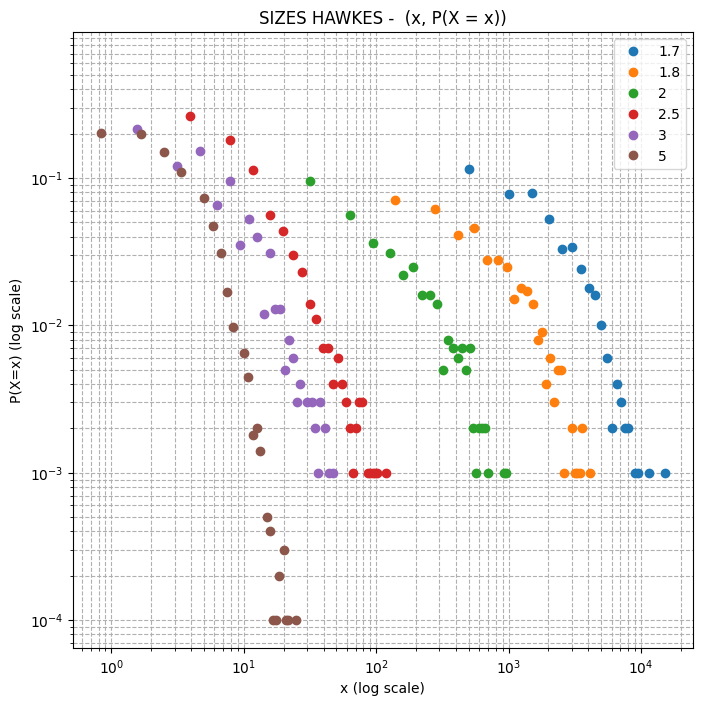

In [286]:
legend = []
series = []
plt.figure(figsize=(8, 8))
for dados, alpha in [[sizesHK17,1.7],[sizesHK18,1.8],[sizesHK2,2],[sizesHK25,2.5],[sizesHK3,3],[sizesHK5,5]]:
    legend.append(str(alpha))
    df_probabilidade, bins, valores_discretizados = get_dfprob(dados)
    plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
    # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')


plt.title('SIZES HAWKES -  (x, P(X = x))')
plt.ylabel('P(X=x) (log scale)')
plt.legend(legend)
plt.xlabel('x (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()


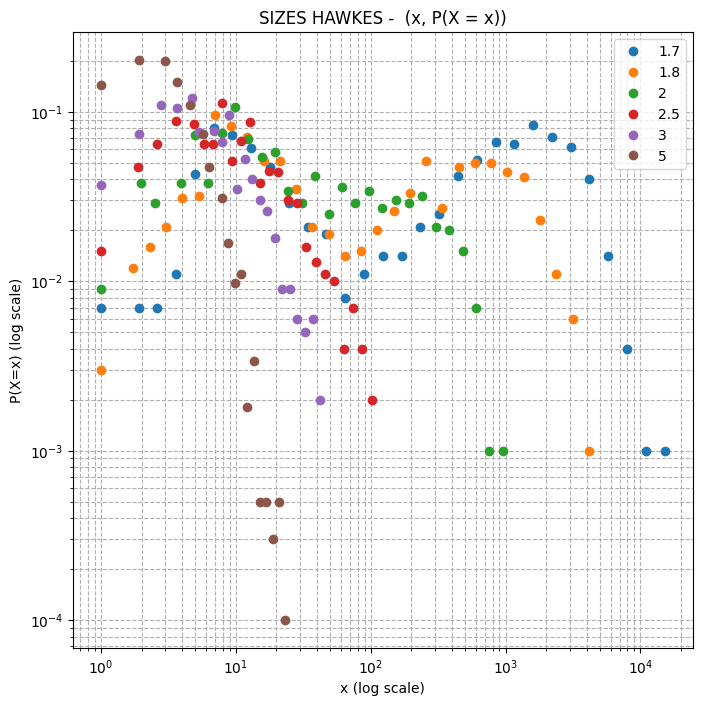

In [287]:
legend = []
series = []
plt.figure(figsize=(8, 8))
for dados, alpha in [[sizesHK17,1.7],[sizesHK18,1.8],[sizesHK2,2],[sizesHK25,2.5],[sizesHK3,3],[sizesHK5,5]]:
    legend.append(str(alpha))
    df_probabilidade, bins, valores_discretizados = get_dfprob_log([dado+1 for dado in dados])
    plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
    # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')


plt.title('SIZES HAWKES -  (x, P(X = x))')
plt.ylabel('P(X=x) (log scale)')
plt.legend(legend)
plt.xlabel('x (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()


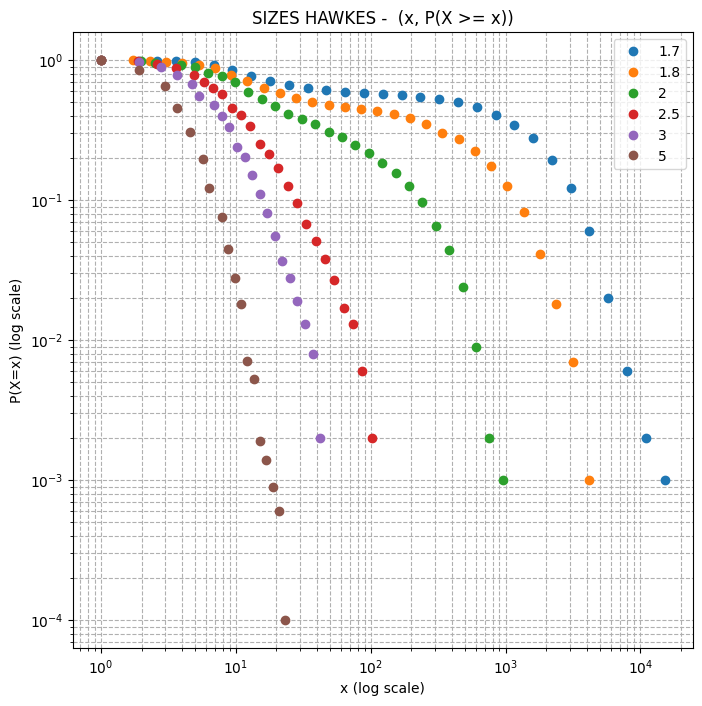

In [288]:
legend = []
series = []
plt.figure(figsize=(8, 8))
for dados, alpha in [[sizesHK17,1.7],[sizesHK18,1.8],[sizesHK2,2],[sizesHK25,2.5],[sizesHK3,3],[sizesHK5,5]]:
    legend.append(str(alpha))
    df_probabilidade, bins, valores_discretizados = get_dfprob_log([dado+1 for dado in dados])
    # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
    plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')


plt.title('SIZES HAWKES -  (x, P(X >= x))')
plt.ylabel('P(X=x) (log scale)')
plt.legend(legend)
plt.xlabel('x (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()


In [114]:
# legend = []
# series = []
# plt.figure(figsize=(8, 8))
# for dados, alpha in [[sizesHK17,1.7],[sizesHK18,1.8],[sizesHK2,2],[sizesHK25,2.5],[sizesHK3,3]]:
#     legend.append(str(alpha))
#     df_probabilidade, bins, valores_discretizados = get_dfprob_log([item+1 for item in dados])
#     plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
#     # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')


# plt.title('SIZES HAWKES -  (x, P(X = x))')
# plt.ylabel('P(X=x) (log scale)')
# plt.legend(legend)
# plt.xlabel('x (log scale)')
# plt.grid(True, which="both", ls="--")
# plt.show()

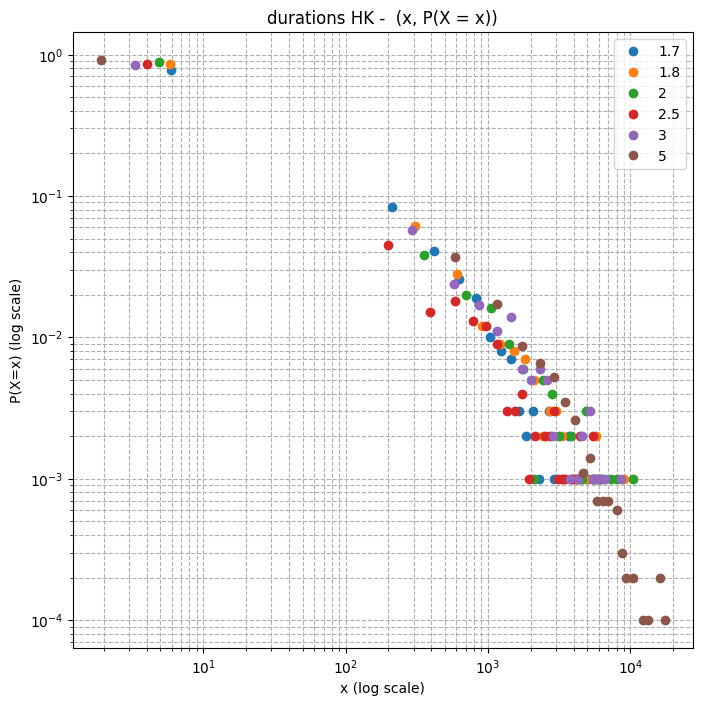

In [289]:
legend = []
series = []
plt.figure(figsize=(8, 8))
for dados, alpha in [[durationsHK17,1.7],[durationsHK18,1.8],[durationsHK2,2],[durationsHK25,2.5],[durationsHK3,3],[durationsHK5,5]]:
    legend.append(str(alpha))
    df_probabilidade, bins, valores_discretizados = get_dfprob(dados)
    plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
    # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')


plt.title('durations HK -  (x, P(X = x))')
plt.ylabel('P(X=x) (log scale)')
plt.legend(legend)
plt.xlabel('x (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()


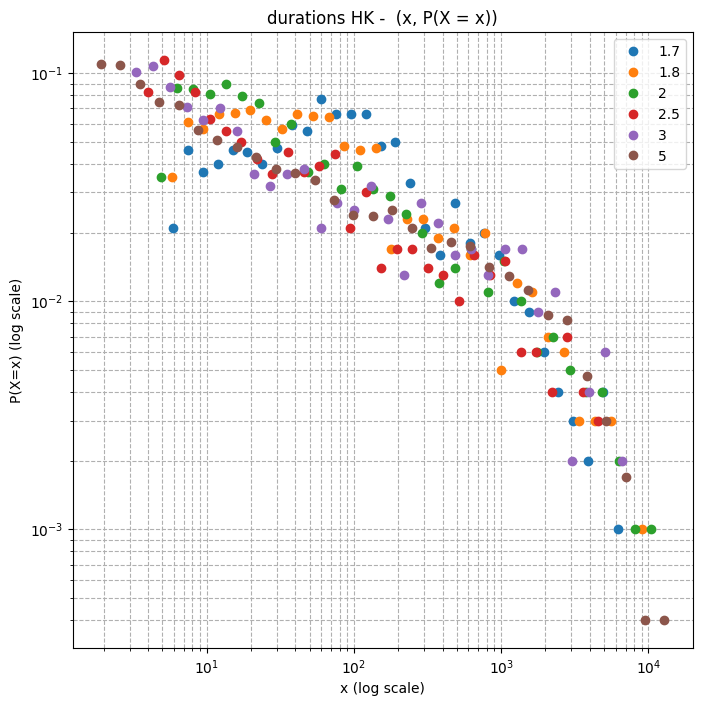

In [290]:
legend = []
series = []
plt.figure(figsize=(8, 8))
for dados, alpha in [[durationsHK17,1.7],[durationsHK18,1.8],[durationsHK2,2],[durationsHK25,2.5],[durationsHK3,3],[durationsHK5,5]]:
    legend.append(str(alpha))
    df_probabilidade, bins, valores_discretizados = get_dfprob_log(dados)
    plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
    # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')


plt.title('durations HK -  (x, P(X = x))')
plt.ylabel('P(X=x) (log scale)')
plt.legend(legend)
plt.xlabel('x (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()


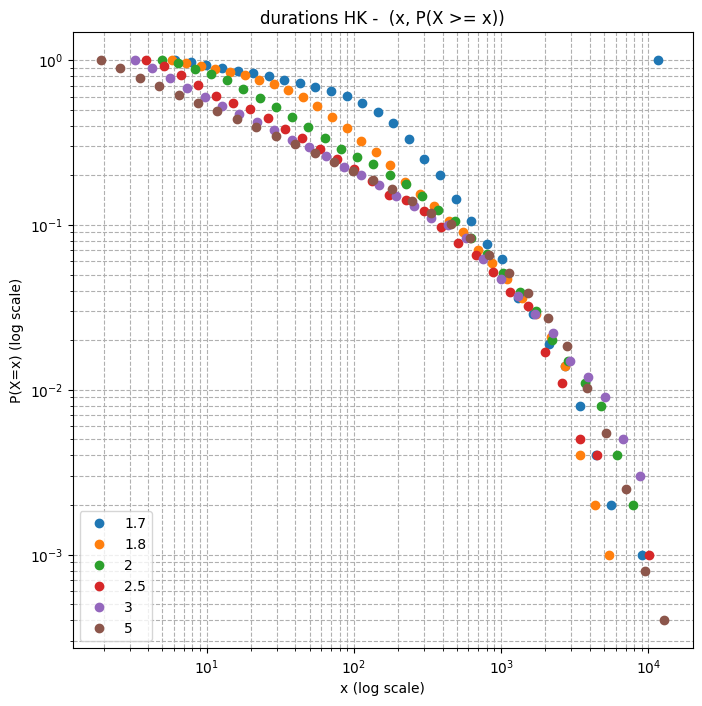

In [267]:
legend = []
series = []
plt.figure(figsize=(8, 8))
for dados, alpha in [[durationsHK17,1.7],[durationsHK18,1.8],[durationsHK2,2],[durationsHK25,2.5],[durationsHK3,3],[durationsHK5,5]]:
    legend.append(str(alpha))
    df_probabilidade, bins, valores_discretizados = get_dfprob_log(dados)
    # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
    plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')


plt.title('durations HK -  (x, P(X >= x))')
plt.ylabel('P(X=x) (log scale)')
plt.legend(legend)
plt.xlabel('x (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()


In [39]:
# plt.hist(durationsHK25)

## -

<!-- ### Sizes -->

In [97]:
# passo = 1
# df_probabilidade, bins, valores_discretizados = get_dfprob(sizes,passo*1000)
# df_probabilidade2, bins2, valores_discretizados2 = get_dfprob(sizes2,passo*1000)
# df_probabilidade3, bins3, valores_discretizados3 = get_dfprob(sizes3,passo)
# df_probabilidade4, bins4, valores_discretizados4 = get_dfprob(sizes4,passo*10)
# # df_probabilidade, bins, valores_discretizados = get_dfprob(sizes/np.mean(sizes),passo)
# # df_probabilidade2, bins2, valores_discretizados2 = get_dfprob(sizes2/np.mean(sizes2),passo)
# # df_probabilidade3, bins3, valores_discretizados3 = get_dfprob(sizes3/np.mean(sizes3),passo)
# # df_probabilidade4, bins4, valores_discretizados4 = get_dfprob(sizes4/np.mean(sizes4),passo)

# plt.figure(figsize=(8, 6))

# plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
# plt.loglog(bins2[valores_discretizados2 - 1], df_probabilidade2['P(X=x)'], marker='o', linestyle='none')
# plt.loglog(bins3[valores_discretizados3 - 1], df_probabilidade3['P(X=x)'], marker='o', linestyle='none')
# plt.loglog(bins4[valores_discretizados4 - 1], df_probabilidade4['P(X=x)'], marker='o', linestyle='none')
# plt.title('SIZES -  (x, P(X = x))')
# plt.ylabel('P(X=x) (log scale)')

# plt.legend(['alpha=1','alpha=0.97','alpha=3','alpha=1.5'])
# # plt.legend(['alpha=0.97','alpha=1','alpha=1.1','alpha=1.3'])
# # plt.legend(['alpha=1.4','alpha=1.3','alpha=1.6','alpha=1.5'])
# plt.xlabel('x (log scale)')
# plt.grid(True, which="both", ls="--")
# plt.show()


In [98]:
# passo = 1
# df_probabilidade, bins, valores_discretizados = get_dfprob(sizes,passo)
# df_probabilidade2, bins2, valores_discretizados2 = get_dfprob(sizes2,passo)
# df_probabilidade3, bins3, valores_discretizados3 = get_dfprob(sizes3,passo)
# df_probabilidade4, bins4, valores_discretizados4 = get_dfprob(sizes4,passo)

# plt.figure(figsize=(8, 6))

# plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')
# plt.loglog(bins2[valores_discretizados2 - 1], df_probabilidade2['P(X>=x)'], marker='o', linestyle='none')
# plt.loglog(bins3[valores_discretizados3 - 1], df_probabilidade3['P(X>=x)'], marker='o', linestyle='none')
# plt.loglog(bins4[valores_discretizados4 - 1], df_probabilidade4['P(X>=x)'], marker='o', linestyle='none')
# plt.title('Log-Log Plot de (x, P(X>=x))')
# plt.ylabel('P(X>=x) (log scale)')

# plt.legend(['alpha=1','alpha=0.97','alpha=1.1','alpha=1.2'])
# plt.xlabel('x (log scale)')
# plt.grid(True, which="both", ls="--")
# plt.show()


<!-- ### Durations -->

In [104]:
# passo = 10
# df_probabilidade, bins, valores_discretizados = get_dfprob(durations,passo)
# df_probabilidade2, bins2, valores_discretizados2 = get_dfprob(durations2,passo)
# df_probabilidade3, bins3, valores_discretizados3 = get_dfprob(durations3,passo)
# df_probabilidade4, bins4, valores_discretizados4 = get_dfprob(durations4,passo)

# # passo = 0.1
# # df_probabilidade, bins, valores_discretizados = get_dfprob(durations/np.mean(durations),passo)
# # df_probabilidade2, bins2, valores_discretizados2 = get_dfprob(durations2/np.mean(durations2),passo)
# # df_probabilidade3, bins3, valores_discretizados3 = get_dfprob(durations3/np.mean(durations3),passo)
# # df_probabilidade4, bins4, valores_discretizados4 = get_dfprob(durations4/np.mean(durations4),passo)

# plt.figure(figsize=(8, 6))

# plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
# plt.loglog(bins2[valores_discretizados2 - 1], df_probabilidade2['P(X=x)'], marker='o', linestyle='none')
# plt.loglog(bins3[valores_discretizados3 - 1], df_probabilidade3['P(X=x)'], marker='o', linestyle='none')
# plt.loglog(bins4[valores_discretizados4 - 1], df_probabilidade4['P(X=x)'], marker='o', linestyle='none')
# plt.title('DURATIONS - (x, P(X = x))')
# plt.ylabel('P(X=x) (log scale)')

# plt.legend(['alpha=1','alpha=0.97','alpha=1.1','alpha=1.2'])
# plt.xlabel('x (log scale)')
# plt.grid(True, which="both", ls="--")
# plt.show()


In [ ]:
# passo = 1
# df_probabilidade, bins, valores_discretizados = get_dfprob(durations,passo)
# df_probabilidade2, bins2, valores_discretizados2 = get_dfprob(durations2,passo)
# df_probabilidade3, bins3, valores_discretizados3 = get_dfprob(durations3,passo)
# df_probabilidade4, bins4, valores_discretizados4 = get_dfprob(durations4,passo)
# plt.figure(figsize=(8, 6))

# plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')
# plt.loglog(bins2[valores_discretizados2 - 1], df_probabilidade2['P(X>=x)'], marker='o', linestyle='none')
# plt.loglog(bins3[valores_discretizados3 - 1], df_probabilidade3['P(X>=x)'], marker='o', linestyle='none')
# plt.loglog(bins4[valores_discretizados4 - 1], df_probabilidade4['P(X>=x)'], marker='o', linestyle='none')
# plt.title('Log-Log Plot de (x, P(X>=x))')
# plt.ylabel('P(X>=x) (log scale)')

# plt.legend(['alpha=1','alpha=0.97','alpha=1.1','alpha=1.2'])
# plt.xlabel('x (log scale)')
# plt.grid(True, which="both", ls="--")
# plt.show()


In [ ]:
# # passo = 1
# # passo = 10
# # passo = 1500
# # passo = 100

# passo = 500
# df_probabilidade, bins, valores_discretizados = get_dfprob(sizes,passo)
# df_probabilidade2, bins2, valores_discretizados2 = get_dfprob(sizes2,passo)
# df_probabilidade3, bins3, valores_discretizados3 = get_dfprob(sizes3,passo)
# # df_probabilidade4, bins4, valores_discretizados4 = get_dfprob(sizes4,passo)

# # passo = 50
# # df_probabilidade, bins, valores_discretizados = get_dfprob(durations,passo)
# # df_probabilidade2, bins2, valores_discretizados2 = get_dfprob(durations2,passo)
# # df_probabilidade3, bins3, valores_discretizados3 = get_dfprob(durations3,passo)
# # df_probabilidade4, bins4, valores_discretizados4 = get_dfprob(durations3,passo)


# plt.figure(figsize=(8, 6))

# # plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')
# # plt.loglog(bins2[valores_discretizados2 - 1], df_probabilidade2['P(X>=x)'], marker='o', linestyle='none')
# # plt.loglog(bins3[valores_discretizados3 - 1], df_probabilidade3['P(X>=x)'], marker='o', linestyle='none')
# # plt.loglog(bins4[valores_discretizados4 - 1], df_probabilidade4['P(X>=x)'], marker='o', linestyle='none')
# # plt.title('Log-Log Plot de (x, P(X>=x))')
# # plt.ylabel('P(X>=x) (log scale)')

# plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
# plt.loglog(bins2[valores_discretizados2 - 1], df_probabilidade2['P(X=x)'], marker='o', linestyle='none')
# plt.loglog(bins3[valores_discretizados3 - 1], df_probabilidade3['P(X=x)'], marker='o', linestyle='none')
# plt.loglog(bins4[valores_discretizados4 - 1], df_probabilidade4['P(X=x)'], marker='o', linestyle='none')
# plt.title('Log-Log Plot de (x, P(X = x))')
# plt.ylabel('P(X=x) (log scale)')

# # plt.legend(['alpha=1','alpha=0.97','alpha=1.1'])
# plt.legend(['alpha=1','alpha=0.97','alpha=1.1','alpha=1.2'])
# plt.xlabel('x (log scale)')
# plt.grid(True, which="both", ls="--")
# plt.show()

# 20/8 -> teste novas phis

523.6540301700117


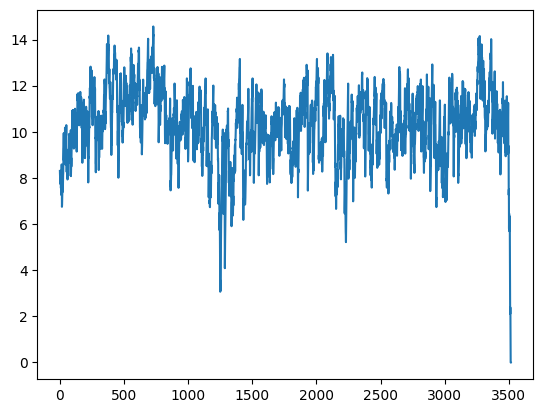

In [119]:
# spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=1, phi=phi, Vmax0=20)
spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V=True, t_sim=np.inf, alpha=1, phi=phi, Vmax0=14.715)
print(trun)
plt.plot([np.mean(item) for item in Vs])

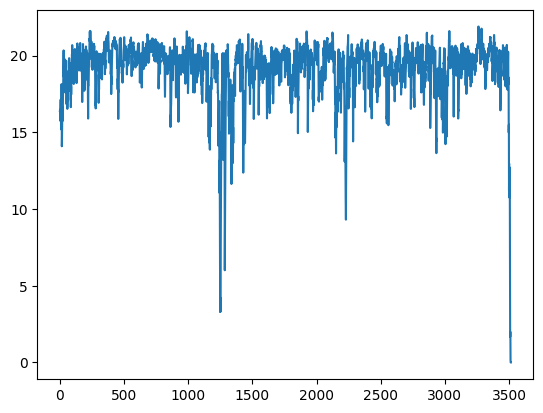

In [120]:
plt.plot([np.sum(item) for item in phis[1:]])

In [134]:
delta_times = []
for i, time in enumerate(times[10:-10],10):
    delta_times.append(times[i+1]-times[i])
max(delta_times), min(delta_times)

(0.3907214551059539, 9.784971410908838e-07)

### Phi_inf

In [ ]:
spk_t2, spk_id2, phis2, times2, Vs2, trun2 = run_simulation(W, reset_V=True, t_sim=10, alpha=1, phi=phi_inf, Vmax0=21, prints=False)
# spk_t2, spk_id2, phis2, times2, Vs2, trun2 = run_simulation(W, reset_V=True, t_sim=10, alpha=2, phi=phi_inf, Vmax0=25, prints=False)

In [ ]:
max_phis2 = [np.max(item) for item in phis2]
min_phis2 = [np.min(item) for item in phis2]
sum_phis2 = [np.sum(item) for item in phis2]
log_sum_phis2 = [np.log10(item) for item in sum_phis2]
mean_Vs2 = [np.mean(item) for item in Vs2]

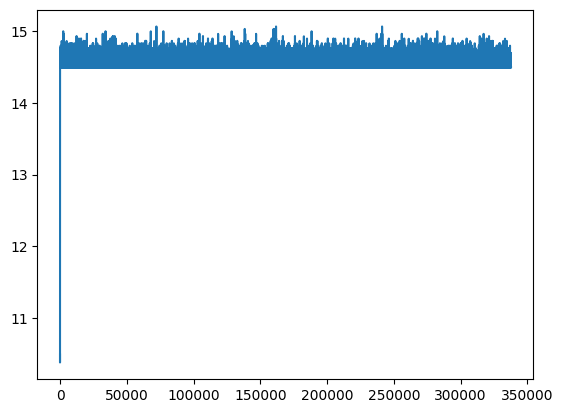

In [139]:
# plot2([pd.Series(mean_Vs2[:5000])])
plt.plot(mean_Vs2)

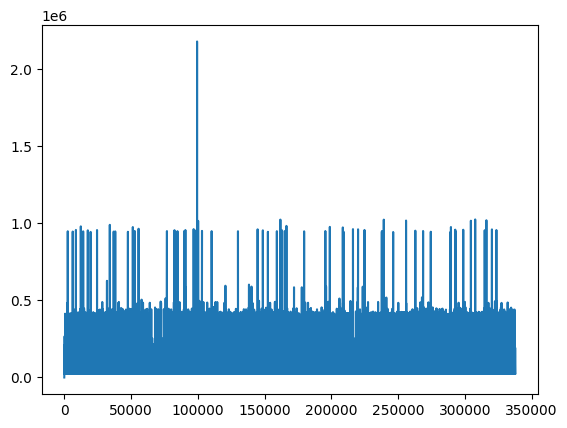

In [140]:
# plot2([pd.Series(sum_phis2[:5000])])
plt.plot(sum_phis2)

C:\Users\ldonaire\AppData\Local\Temp\ipykernel_20732\554405477.py:8: RuntimeWarning:

invalid value encountered in divide



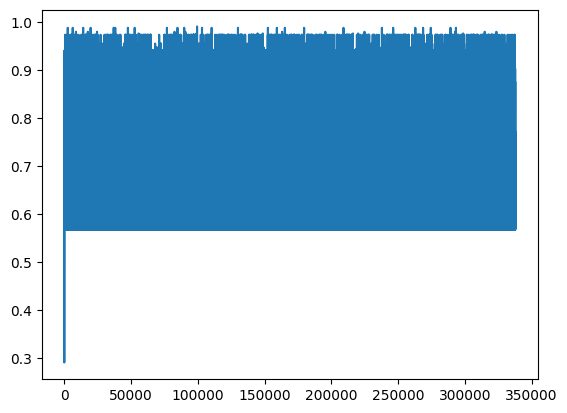

In [141]:
# plt.hist(mean_Vs2, bins=[14.3,14.35,14.4,14.45,14.5,14.55,14.6,14.65,14.7,14.8,14.9,15,15.1])


# plt.plot(sum_phis2)
# plt.plot(max_phis2, alpha=0.8)


plt.plot(np.array(max_phis2)/np.array(sum_phis2))


# plt.plot(log_sum_phis2)

# plt.hist(log_sum_phis2, bins=(np.array(range(40,61))/10))

#### W random

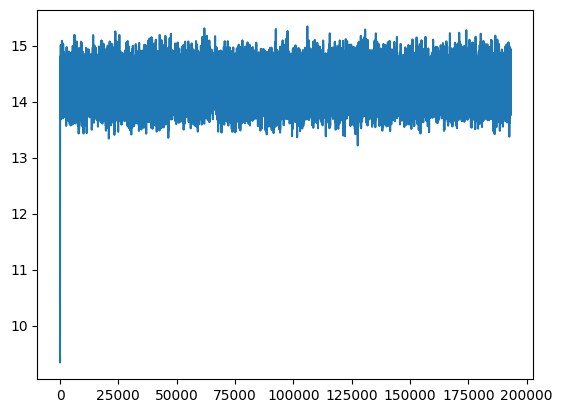

In [145]:
spk_t3, spk_id3, phis3, times3, Vs3, trun3 = run_simulation(Wrandom, reset_V=True, t_sim=10, alpha=1, phi=phi_inf, Vmax0=21, prints=False)
mean_Vs3 = [np.mean(item) for item in Vs3]
plt.plot(mean_Vs3)

## Métricas

In [ ]:
# Firing rate, IF curve, Inter-Spike-Interval, Coef. Variation, etc...

## 3/5

### Tuning de params
N = 30

Kw = 1

phimax = 1

phimin = 0

beta = 0.5

v_half = 7

COM ISSO, phi(14.715) = 0.95

entao v_0 = unif(0, 14.715)

queremos alpha critico, estudar alpha (qdo normal, qdo exponencial)

testes de “exponencialiadade”

In [55]:
from scipy.stats import kstest, expon, shapiro, norm
def test_exponenciality(dados, confidence=0.95, Lambda=1):
    if pd.isnull(Lambda):
        loc, LambdaInv = expon.fit(dados)
        Lambda = 1/LambdaInv
        print(f'loc, Lambda = {loc},{Lambda}')
    statistic, p_value = kstest(dados, 'expon', args=(0, 1/Lambda))
    # return p_value > 1-confidence
    return [p_value, p_value > 1-confidence]

In [209]:
def test_normality(dados, confidence=0.95):
    statistic, p_value = shapiro(dados)
    return p_value > 1-confidence
    # return [p_value, p_value > 1-confidence] # p_valor, NAO REJEITAMOS H0?

In [265]:
dados_normais = norm.rvs(loc=0,scale=1,size=1000)
dados_exp = expon.rvs(scale=1, size=1000)
print(test_exponenciality(dados_exp))
print(test_exponenciality(dados_normais))
print(test_normality(dados_normais))
print(test_normality(dados_exp))

[np.float64(0.4748599041740078), np.True_]
[np.float64(3.79739190845244e-240), np.False_]
True
False


## Teste de alpha critico

In [266]:
def teste_exponencialidade(alpha, num_simulacoes=300, reset_V=True, plot=True):
    # dados_simulacoes = []
    times_death = []
    for i in range(num_simulacoes):
        spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, reset_V, np.inf, alpha)
        times_death.append(trun)
        # dados_simulacoes.append([spk_t, spk_id, phis, times, Vs, trun])

    dados = np.array(times_death)/np.mean(times_death)
    if plot:
        plt.title(f'alpha={alpha}, exp={test_exponenciality(dados)}')
        plt.hist(dados, bins=[item/5 for item in range(15*10)], density=True)
        plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
        plt.show()
    return test_exponenciality(dados)#, dados_simulacoes




def varredura(reset_V, alpha0, passo, trials=300):
    resultados = {}
    # dicio_simulacoes = {}
    alpha = alpha0
    last_exponencial = False
    
    while alpha > 0:
        print(f'testando alpha = {alpha}, em {pd.Timestamp.now()}')
        # [p_value, exponencial], simulacoes = teste_exponencialidade(alpha, trials, reset_V)
        [p_value, exponencial] = teste_exponencialidade(alpha, trials, reset_V)
        resultados[alpha] = exponencial
        # dicio_simulacoes[alpha] = simulacoes

        print(alpha, exponencial, p_value)
        if not exponencial: 
            last_nao_exp = alpha
        
        if exponencial and last_exponencial:
            # return resultados, dicio_simulacoes, last_nao_exp, last_alpha # alpha nao exponencial e alpha exponencial.
            return resultados, last_nao_exp, last_alpha # alpha nao exponencial e alpha exponencial.

        last_alpha, last_exponencial = alpha, exponencial
        alpha -= passo

    if alpha <= 0:
        print('deu bolete - alpha <= 0')
        # return resultados, dicio_simulacoes, None, None
        return resultados, None, None

In [16]:
spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, False, np.inf, alpha=1.6)

In [ ]:
x = np.arange(0,20,0.01)
y = phi(x)
plt.plot(x,y)

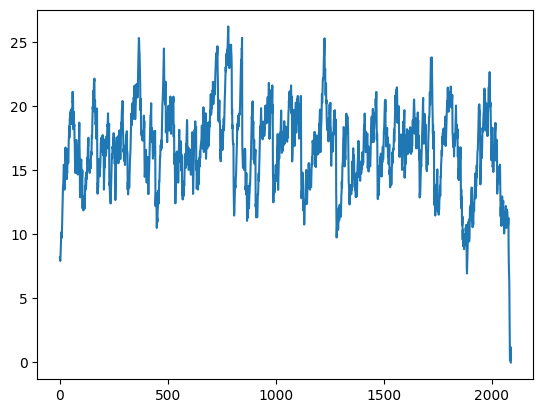

In [17]:
plt.plot([np.mean(item) for item in Vs])

#### Varredura Integra e Dispara

testando alpha = 1.03, em 2024-08-20 18:25:33.701779


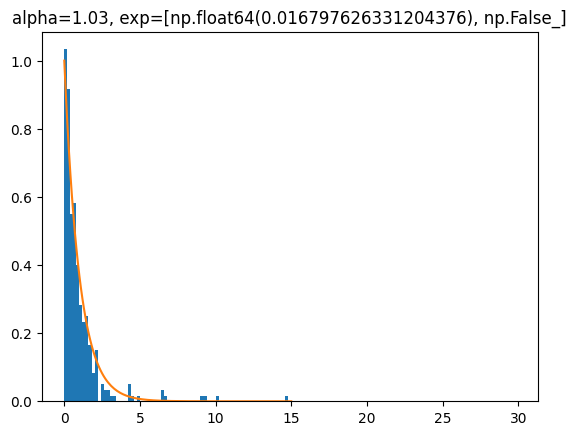

1.03 False 0.016797626331204376
testando alpha = 1.02, em 2024-08-20 18:26:22.318166


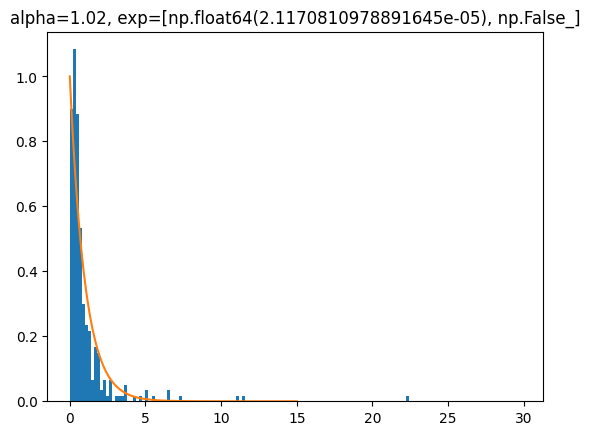

1.02 False 2.1170810978891645e-05
testando alpha = 1.01, em 2024-08-20 18:27:21.933290


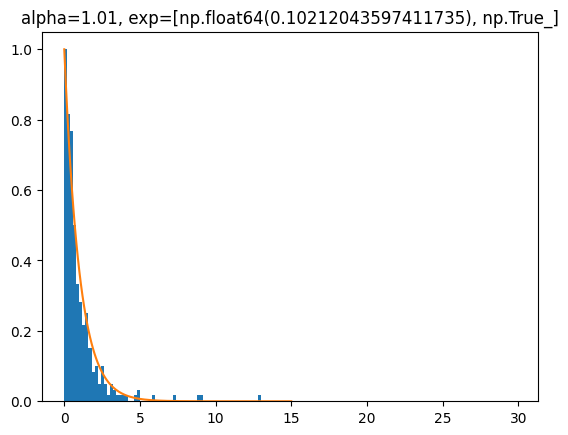

1.01 True 0.10212043597411735
testando alpha = 1.0, em 2024-08-20 18:28:50.963949


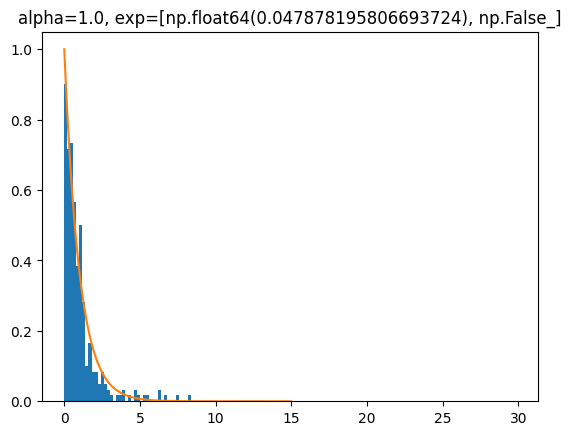

1.0 False 0.047878195806693724
testando alpha = 0.99, em 2024-08-20 18:30:35.503450


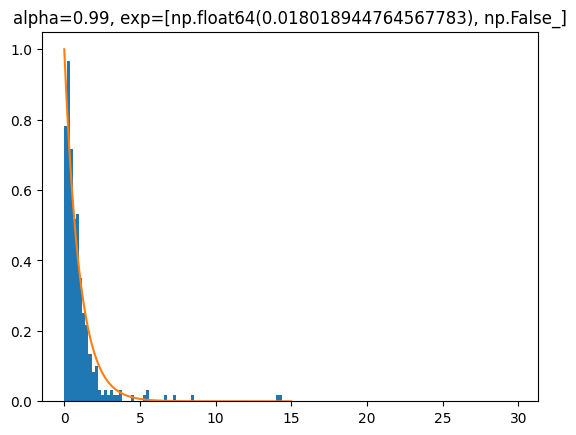

0.99 False 0.018018944764567783
testando alpha = 0.98, em 2024-08-20 18:32:32.207669


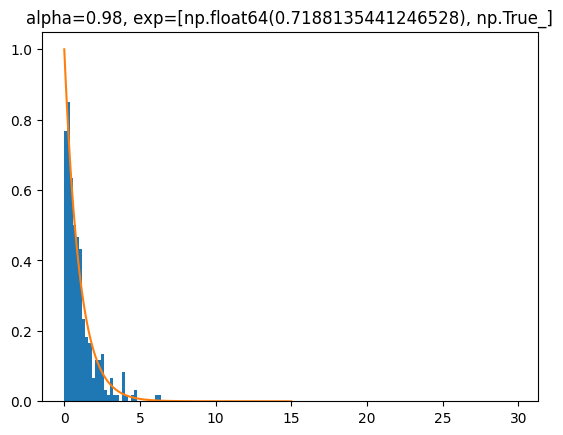

0.98 True 0.7188135441246528
testando alpha = 0.97, em 2024-08-20 18:35:10.986491


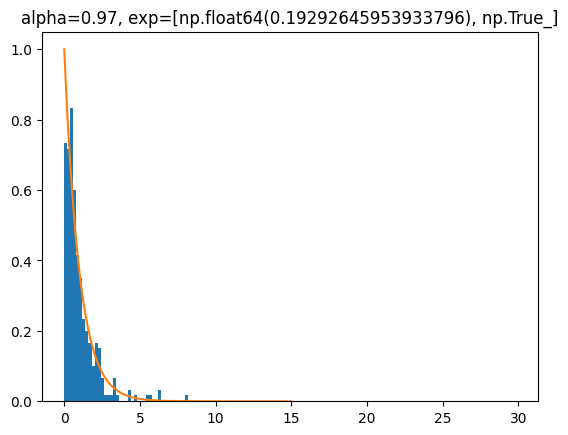

0.97 True 0.19292645953933796


In [267]:
# varredura(True, 1.1, 0.05)
# varredura(True, 1.05, 0.01)
# varredura(True, 1.02, 0.01, 500)

dados_v1 = varredura(True, 1.03, 0.01)

In [268]:
dados_v1

({1.03: np.False_,
  1.02: np.False_,
  1.01: np.True_,
  1.0: np.False_,
  0.99: np.False_,
  0.98: np.True_,
  0.97: np.True_},
 0.99,
 0.98)

#### Varredura Hawkes

testando alpha = 1.5, em 2024-08-20 18:42:39.193111


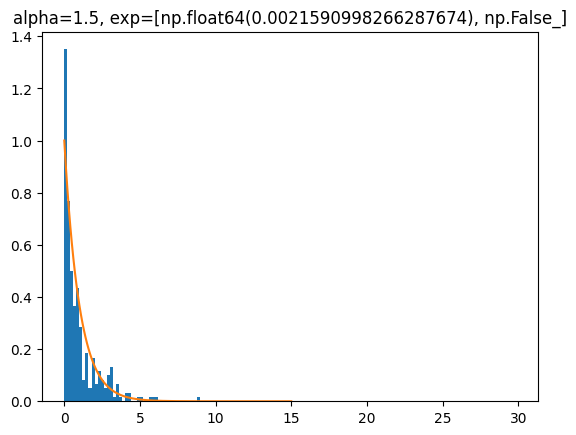

1.5 False 0.0021590998266287674
testando alpha = 1.45, em 2024-08-20 19:03:43.139407


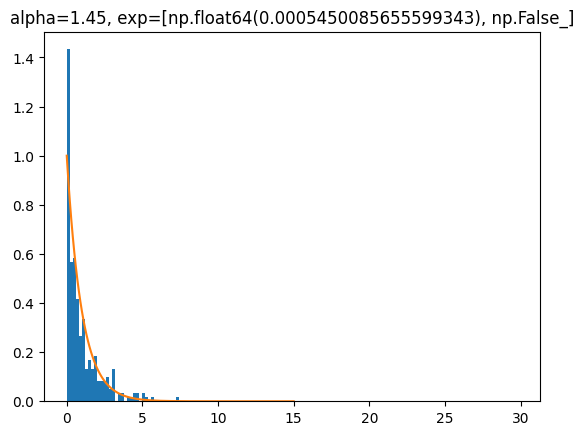

1.45 False 0.0005450085655599343
testando alpha = 1.4, em 2024-08-20 20:18:49.582647


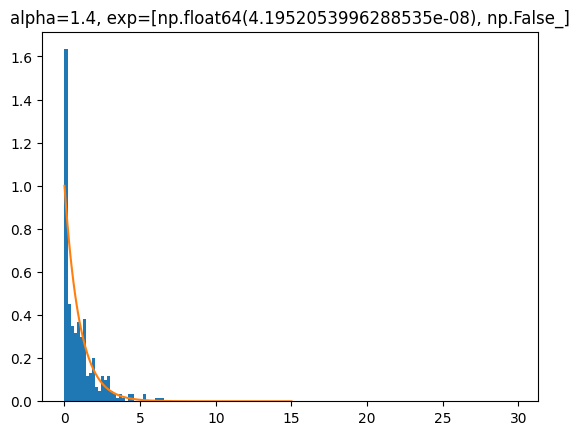

1.4 False 4.1952053996288535e-08
testando alpha = 1.3499999999999999, em 2024-08-21 00:07:33.336037


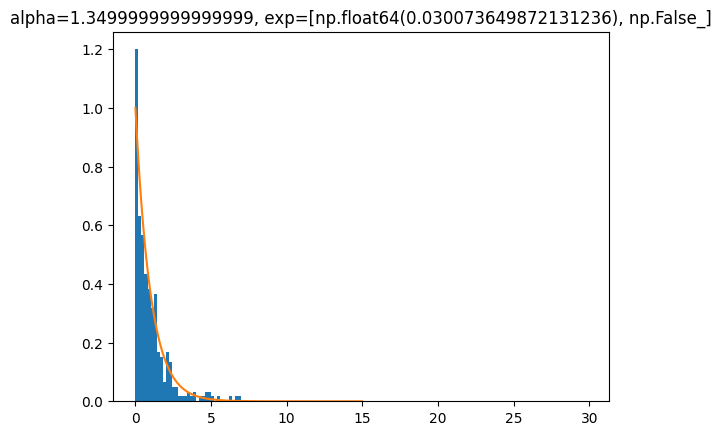

1.3499999999999999 False 0.030073649872131236
testando alpha = 1.2999999999999998, em 2024-08-21 17:07:11.547664


In [269]:
dados_v2 = varredura(False, 1.5, 0.05, 300)

In [ ]:
# varredura(False, 1.4, 0.05, 300)

<!-- # Delay + Testando criticalidade - 1/9 -->

In [18]:
def is_crescent(array):
    return all(array[i] < array[i + 1] for i in range(len(array) - 1))

def run_simulation2(W, reset_V=True, t_sim=t_sim, alpha=alpha, phi=phi, prints=False, delta_unchange=0.1, V_start_mode='random',Vmax0=14.715, Vmin0=0, V0=[]):
    #initial conditions
    phis = []
    times = []
    Vs = []
    Dts = []
    Phi_Sums = []
    
    N = len(W)
    if V_start_mode == 'random' or len(V0)!=N:
        print('W Start Random')
        V = np.random.uniform(Vmin0, Vmax0, size=N) 
    else:
        V = V0

    phi_u = np.zeros(N)          #array to store phi values
    last_spike = np.zeros(N)

    # arrays to store spikes
    spk_t = [] # tempo do spike
    spk_id = [] # id do neuronio (0 a N-1) que teve o spike
    
    trun = 0.0

    times.append(trun)
    phis.append(phi_u)
    Vs.append(V)
    Dts.append(0)

    j = 0
    while (trun < t_sim):
        j+=1
        ALL=all(V<0.001)
        if ALL: 
            # print('MORREU EM', trun)
            # print('\nNumber of spikes per neuron: ' + str(len(spk_t)/N))
            return np.array(spk_t), np.array(spk_id), phis, times, Vs, trun, Dts
        

        
        # compute phi(T-dt)
        phi_u = phi(V)
        S = np.sum(phi_u)
        if S == 0: 
            print('S==0')
            break
        # print(S)

        dt = np.random.exponential(scale=1/S) # jogar exponencial de taxa soma(phi)
        
        #compute V(T)
        V_old = V
        expoent = -alpha * max([0, dt-delta_unchange]) # delay
        # if prints:
        #     if expoent != 0: 
        #         print()
        #         print()
        #         print('EXP = ',expoent)
        #         print('EXP = ',expoent)
        #         print('EXP = ',expoent)
        #         print()
        #         print()
        V = V*np.exp(expoent)
        # V = (V)*np.exp(-alpha*dt)

        # phi em T
        phi_u = phi(V) 

        # joga uniforme

        unif = np.random.uniform(low=0.0, high=S)
        S_new = np.sum(phi_u)
        Phi_Sums.append(S_new)
        trun += dt
        if prints:
            if expoent != 0 and delta_unchange>0:
                print()
                print()
                print('EXP = ',expoent)
                print('EXPONEN = ',np.exp(expoent))
                print('dt ',dt)
                print('V soma 1 ',sum(V_old))
                print('V soma 2 ',sum(V))
                print('Phi soma 1 ',S)
                print('Phi soma 2 ',S_new)
                print('Unif ',unif)
                print('t_run ',trun)
                print()
                print()
            if j % 2000 == 0:
                print()
                print('step ',j)
                print('t_run ',trun)
                print('V soma 1 ',sum(V_old))
                print('V soma 2 ',sum(V))
                print('EXP = ',expoent)
                print('EXPONEN = ',np.exp(expoent))
                print('dt ',dt)
                print('Phi soma 1 ',S)
                print('Phi soma 2 ',S_new)
                print('Unif ',unif)
        if len(Phi_Sums)> 3000:
            if is_crescent(Phi_Sums[-4000:][::200]):
                print('EXPLODIU')
                print(Phi_Sums[-4000:][::200])
                return np.array(spk_t), np.array(spk_id), phis, times, Vs, trun, Dts

        times.append(trun)
        phis.append(phi_u)
        Vs.append(V)
        Dts.append(dt)

        if unif<=S_new:
            phi_cumsum = np.cumsum(phi_u)
            neuron_id = np.where(unif<=phi_cumsum)[0][0] # acha o neuronio tal que a uniforme caiu nele
            # print('SPIKE', neuron_id)

            # checking refractory period
            if last_spike[neuron_id]==0 or (trun-last_spike[neuron_id])>=t_ref:

                # updating of postsynaptic currents:
                V = V+W[neuron_id]
                # V = W[neuron_id]
                last_spike[neuron_id] = trun
                # recording spike time and neuron index:
                spk_t.append(trun)
                spk_id.append(neuron_id)
                if reset_V:
                    V[neuron_id] = V_reset # Zera potencial


    # print('\nNumber of spikes per neuron: ' + str(len(spk_t)/N))
    # print('acabou a simulação')
    return np.array(spk_t), np.array(spk_id), phis, times, Vs, trun, Dts

In [12]:
N = 3000 # number of neurons
Kw = 4
W = Kw * (np.ones((N,N)) - np.eye(N))
W.sum()

np.float64(35988000.0)

In [13]:
N = 300 # number of neurons
Wrandom = np.random.random_sample((N,N))
Wrandom -= Wrandom*np.eye(N)
Wrandom.sum() #- 35988000

np.float64(44946.706993153784)

T Run  0.07812840790136892
len dt 4
0    0.000000
1    0.005378
2    0.019190
3    0.053561
dtype: float64


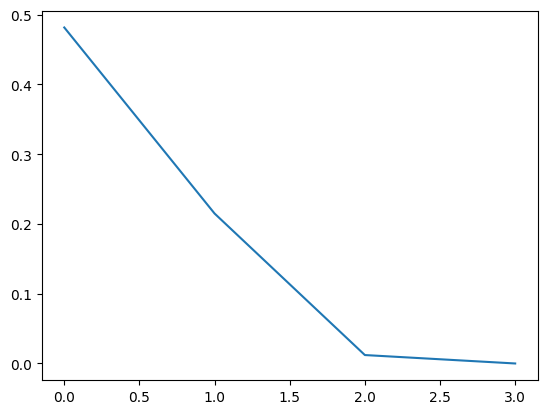

In [15]:
# spk_t, spk_id, phis, times, Vs, trun, Dts = run_simulation2(W, reset_V=True, t_sim=50, alpha=10000, phi=phi_inf, Vmax0=20, prints=True, Vmin0=15, delta_unchange=0.01)
# spk_t, spk_id, phis, times, Vs, trun, Dts = run_simulation2(W, reset_V=True, t_sim=np.inf, alpha=10000, phi=phi_inf, Vmax0=20, prints=False, Vmin0=0, delta_unchange=0.005)
# spk_t, spk_id, phis, times, Vs, trun, Dts = run_simulation2(W, reset_V=True, t_sim=np.inf, alpha=1000000, phi=phi_inf, prints=True, delta_unchange=0.005, V_start_mode='fixed', V0 = W[0])
# spk_t, spk_id, phis, times, Vs, trun, Dts = run_simulation2(W, reset_V=True, t_sim=np.inf, alpha=5000, phi=phi_ident, prints=True, delta_unchange=0.0, V_start_mode='fixed', V0 = W[0])
# spk_t, spk_id, phis, times, Vs, trun, Dts = run_simulation2(W, reset_V=False, t_sim=np.inf, alpha=10000, phi=phi_ident, prints=True, delta_unchange=0.0, V_start_mode='fixed', V0 = W[0])
spk_t, spk_id, phis, times, Vs, trun, Dts = run_simulation2(W=Wrandom, reset_V=False, t_sim=np.inf, alpha=150, phi=phi_ident, prints=True, delta_unchange=0.0, V_start_mode='fixed', V0 = Wrandom[0])
print('T Run ',trun)
print('len dt', len(Dts))
print(pd.Series(Dts).sort_values().tail(10))
plt.plot([np.mean(item) for item in Vs])

In [38]:
# plt.plot([np.mean(item) for item in phis[-2000:]][::100])

# is_crescent([np.mean(item) for item in phis[-4000:-2000]][::50])

In [27]:
# np.exp(-0.005*450)
# np.exp(-0.005*1000)

In [198]:
# sizes = []
# durations = []
sizes2 = []
durations2 = []
for ii in range(2000):
    if ii % 50 == 0: print(ii)
    # spk_t, spk_id, phis, times, Vs, trun, Dts = run_simulation2(W, reset_V=True, t_sim=np.inf, alpha=1000000, phi=phi_inf, prints=False, delta_unchange=0.005, V_start_mode='fixed', V0 = W[0])
    # spk_t, spk_id, phis, times, Vs, trun, Dts = run_simulation2(W, reset_V=True, t_sim=np.inf, alpha=5000, phi=phi_ident, prints=True, delta_unchange=0.0, V_start_mode='fixed', V0 = W[0])
    # spk_t, spk_id, phis, times, Vs, trun, Dts = run_simulation2(W, reset_V=False, t_sim=np.inf, alpha=5000, phi=phi_ident, prints=True, delta_unchange=0.0, V_start_mode='fixed', V0 = W[0])

    # spk_t, spk_id, phis, times, Vs, trun, Dts = run_simulation2(W=Wrandom, reset_V=False, t_sim=10, alpha=10000, phi=phi_ident, prints=True, delta_unchange=0.0, V_start_mode='fixed', V0 = W[0])
    spk_t, spk_id, phis, times, Vs, trun, Dts = run_simulation2(W=Wrandom, reset_V=False, t_sim=np.inf, alpha=150, phi=phi_ident, prints=False, delta_unchange=0.0, V_start_mode='fixed', V0 = Wrandom[0])
    # durations.append(trun)
    # sizes.append(len(spk_t))
    durations2.append(trun)
    sizes2.append(len(spk_t))


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950


In [16]:
# get_code_read_pkl("write_pkl([durations, sizes],'Avalanches_1000trials_alpha1000000_phiinf_delta0005_N3000_W17_ResetAllV')")
[durations, sizes] = read_pkl("Avalanches_1000trials_alpha1000000_phiinf_delta0005_N3000_W17_ResetAllV")
# write_pkl([durations, sizes],'Avalanches_1000trials_alpha1000000_phiinf_delta0005_N3000_W17_ResetAllV')
# run_simulation2(W, reset_V=True, t_sim=np.inf, alpha=1000000, phi=phi_inf, prints=True, delta_unchange=0.005, V_start_mode='fixed', V0 = W[0])
# L115 : V = W[neuron_id]
# N = 3000 
# Kw = 17

In [284]:
# pd.Series(durations).sort_values()[:-1]

In [ ]:
# plt.hist(sizes)
# plt.hist(durations)
# plt.hist(pd.Series(durations).sort_values()[:-20])

In [150]:
# sizes2

In [28]:
# dados = sizes2
# dados = durations2
# dados = sizes
dados = durations
dados = pd.Series(durations).sort_values()[:-20].values

passo = 0.2
bins = np.arange(min(dados), max(dados) + passo, passo)
bins_discretizados = np.digitize(dados, bins)

# Calculando a função de probabilidade P(X=x)
valores_discretizados, contagem = np.unique(bins_discretizados, return_counts=True)
probabilidade_empirica = contagem / len(dados)

# Criando um DataFrame para organizar os resultados
df_probabilidade = pd.DataFrame({
    'Bin': bins[valores_discretizados - 1],
    'P(X=x)': probabilidade_empirica
})

# Calculando a função de distribuição acumulada P(X>=x)
df_probabilidade['P(X>=x)'] = df_probabilidade['P(X=x)'][::-1].cumsum()[::-1]

# print(df_probabilidade)

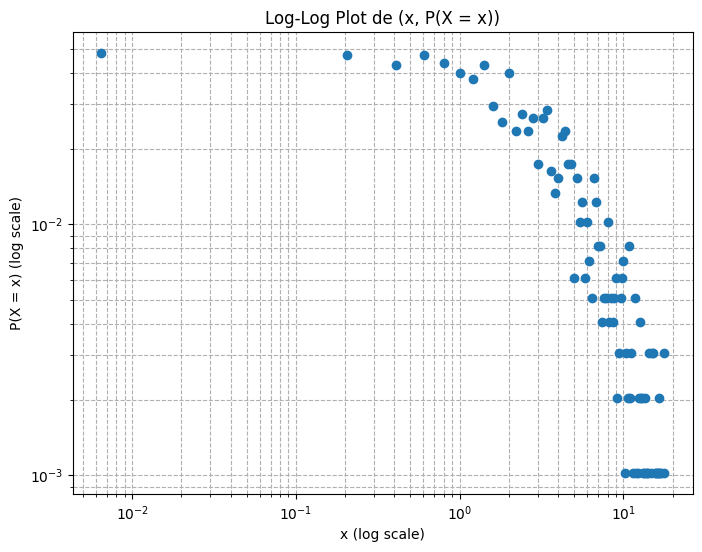

In [29]:
plt.figure(figsize=(8, 6))
# plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X>=x)'], marker='o', linestyle='none')
plt.loglog(bins[valores_discretizados - 1], df_probabilidade['P(X=x)'], marker='o', linestyle='none')
plt.xlabel('x (log scale)')
plt.ylabel('P(X = x) (log scale)')
plt.title('Log-Log Plot de (x, P(X = x))')
plt.grid(True, which="both", ls="--")
plt.show()

<!-- # [OLD] Guardar -->

(False, False)

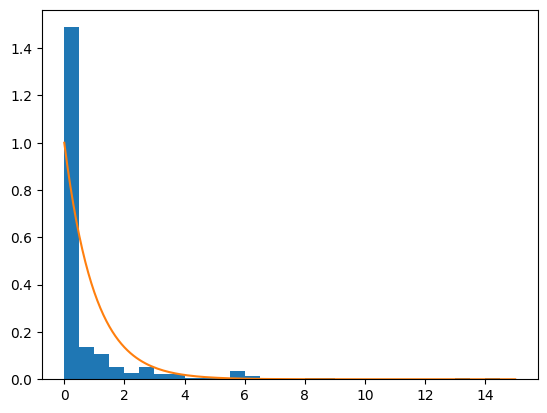

In [23]:
# alpha = 1.01
# alpha = 0.95
alpha = 2
dados_simulacoes = []
times_death = []
for sim in range(300):
    # if sim % 10 == 0:
        # print(sim)
    spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, False, np.inf, alpha)
    times_death.append(trun)
    dados_simulacoes.append([spk_t, spk_id, phis, times, Vs])

# dados = np.array(times_death)/np.mean(times_death)
# test_exponenciality(dados), test_normality(dados)

dados = np.array(times_death)/np.mean(times_death)
plt.hist(dados, bins=[item/2 for item in range(31)], density=True)
plt.plot([item/10 for item in range(151)], np.exp(-np.array([item/10 for item in range(151)])))
test_exponenciality(dados), test_normality(dados)

<!-- ## Pré 16/3 -->

In [ ]:
# times_death = []
# for sim in range(300):
#     if sim % 10 == 0:
#     print(sim)
#     spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, True, np.inf)
#     times_death.append(trun)

In [ ]:
# len(times_death)

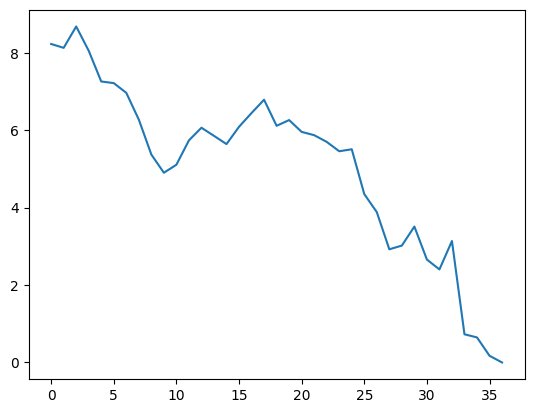

In [ ]:
spk_t, spk_id, phis, times, Vs, trun = run_simulation(W, True, np.inf, 2)
plt.plot([np.mean(item) for item in Vs])

In [ ]:
# plt.hist(times_death/np.mean(times_death), bins=[item/8 for item in range(80)],density=True)
# plt.hist(times_death/np.mean(times_death), bins=[item/2 for item in range(20)],density=True)
# x = np.arange(0,10,0.01)
# y = np.exp(-x)
# plt.plot(x,y)

In [ ]:
# times_death
# np.mean(times_death)

In [ ]:

exp1 = np.random.exponential(1, 500)
exp2 = np.random.exponential(1/2, 500)
exp3 = np.random.exponential(1/3, 500)
exp4 = np.random.exponential(1/4, 500)

plt.hist(times_death/np.mean(times_death), bins=[item/2 for item in range(20)])
plt.hist(exp1,bins=[item/2 for item in range(20)],alpha=0.5)
plt.legend(['T/mean(T)','Exp(1)'])
plt.show()
plt.hist(times_death/np.mean(times_death), bins=[item/2 for item in range(20)])
plt.hist(exp2,bins=[item/2 for item in range(20)],alpha=0.5)
plt.legend(['T/mean(T)','Exp(2)'])
plt.show()
plt.hist(times_death/np.mean(times_death), bins=[item/2 for item in range(20)])
plt.hist(exp3,bins=[item/2 for item in range(20)],alpha=0.5)
plt.legend(['T/mean(T)','Exp(3)'])
plt.show()
plt.hist(times_death/np.mean(times_death), bins=[item/2 for item in range(20)])
plt.hist(exp4,bins=[item/2 for item in range(20)],alpha=0.5)
plt.legend(['T/mean(T)','Exp(4)'])
plt.show()

In [ ]:
T = times_death/np.mean(times_death)
np.mean(T), np.var(T), np.mean(times_death)

(1.0000000000000002, 3.8014495582313383, 4395.33657976549)

In [ ]:
# exp2 = []
# exp1 = []
# for sim in range(500):
#     exp1.append(np.random.exponential(1))
#     exp2.append(np.random.exponential(0.5))

# plt.hist(exp2, bins=range(10))
# plt.hist(exp1,bins=range(10),alpha=0.5)

In [ ]:
# dt1 = 0.764763
# dt2 = 1.160524
# V0 = 0.702309
# V1 = 0.650601
# V2 = 1.586553

# V1 * np.exp( - alpha * (dt2-dt1)) + 1

V0 = Vs[0][0]
V1 = Vs[1][0]
V2 = Vs[2][0]
dt1 = times[1]
dt2 = times[2]

# V1 * np.exp( - alpha * (dt2-dt1)) + 1
# V0 * np.exp( - alpha * (dt1)), V1
# V1 * np.exp( - alpha * (dt2-dt1)) + 1, V2
(V1+1) * np.exp( - alpha * (dt2-dt1)) , V2

(1.833868560044904, 1.833868560044904)

In [ ]:
import pandas as pd
pd.DataFrame(Vs, index=times)

,0,1,2,3,4
0.000000,0.899980,0.599696,0.149937,0.426878,0.679680
0.475849,0.858158,0.571828,0.142969,0.407041,0.648095
0.607427,1.833869,1.551282,1.128028,0.000000,1.626552
1.402099,2.617384,2.356385,1.965465,0.923608,0.000000
2.787863,3.149283,2.922058,0.000000,1.674687,0.870597
2.913424,4.097510,0.000000,0.987522,2.641313,1.847256


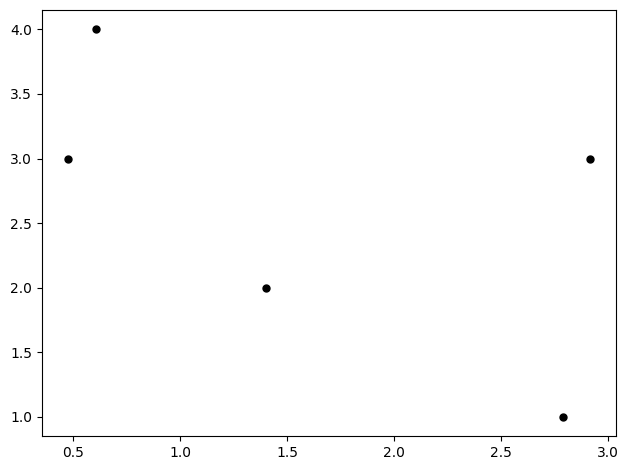

In [ ]:
plt.plot(spk_t, spk_id, '.k', markersize=10.0)
plt.tight_layout()
plt.show()

In [ ]:
# [spk_t, spk_id, phis, times, Vs][4][0]
# [spk_t, spk_id, phis, times, Vs][4], times
# Vs[:], times[:]

# for i in range(len(times)):
# for i in range(5):
#     print()
#     print(times[i])
#     print(Vs[i])
#     print(phis[i])

# somas = [sum(phi) for phi in phis]
# plt.plot(somas)

In [ ]:



# def phi2(V, v_half, slope):
#     return 1.0/(1.0+np.exp(-(V-v_half)/slope))
#     return (1/27.07) * np.exp((V-v_half)/slope) + 1e-4
#     phi_u = slope*V#+0.1
#     phi_u[phi_u>1] = 1
#     phi_u[phi_u<0] = 0
#     return phi_u

In [ ]:
# V = np.arange(-10,100,1)
# p = phi(V, gamma,0.4)
# plt.plot(V, p)
# p = phi(V, gamma,0.8)
# plt.plot(V, p)
# p = phi2(V, 0,5)
# plt.plot(V, p)

<!-- # Teste -->

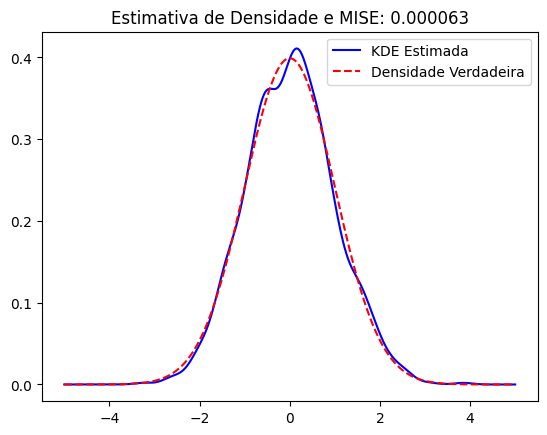

MISE: 0.000063


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

# 1. Gerar dados da distribuição verdadeira (normal padrão)
np.random.seed(42)
n_samples = 1000
dados = np.random.normal(0, 1, n_samples)

# 2. Estimar a densidade usando Kernel Density Estimation (KDE)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(dados[:, np.newaxis])

# 3. Criar uma grade de valores no eixo x
x_grid = np.linspace(-5, 5, 1000)
log_densidade_kde = kde.score_samples(x_grid[:, np.newaxis])
densidade_kde = np.exp(log_densidade_kde)

# 4. Densidade verdadeira da distribuição normal
densidade_verdadeira = norm.pdf(x_grid, 0, 1)

# 5. Calcular o erro quadrado (MISE)
# Integração aproximada (somatório da diferença ao quadrado entre as densidades)
mise = np.mean((densidade_kde - densidade_verdadeira)**2)

# 6. Visualizar as densidades estimada e verdadeira
plt.plot(x_grid, densidade_kde, label='KDE Estimada', color='blue')
plt.plot(x_grid, densidade_verdadeira, label='Densidade Verdadeira', color='red', linestyle='--')
plt.title(f"Estimativa de Densidade e MISE: {mise:.6f}")
plt.legend()
plt.show()

print(f"MISE: {mise:.6f}")

In [17]:
# dados

In [15]:
# get_code_read_pkl("write_pkl([sizes,durations,sizes2,durations2],'Sizes_Durations_2000Trials_WUnif_alpha1_and_alpha097_phi_Vmax0_14p715')")
[sizes,durations,sizes2,durations2] = read_pkl("Sizes_Durations_2000Trials_WUnif_alpha1_and_alpha097_phi_Vmax0_14p715")

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity


In [17]:
# dados = sizes2
# dados = sizes
# dados = durations
# dados = durations2/np.mean(durations2)


# dados1 = durations2/np.mean(durations2)
# dados = np.concatenate([dados1,-dados1])

dados1 = durations2/np.mean(durations2)
dados = np.log(dados1)

In [79]:
# pd.Series(dados1).hist()

In [ ]:

kde = KernelDensity(kernel='gaussian', bandwidth=1000000).fit(np.array(dados)[:,np.newaxis])
kde2 = KernelDensity(kernel='gaussian', bandwidth=50).fit(np.array(dados)[:,np.newaxis])
# kde3 = KernelDensity(kernel='gaussian', bandwidth=1).fit(np.array(dados)[:,np.newaxis])
kde3 = KernelDensity(kernel='gaussian', bandwidth=10).fit(np.array(dados)[:,np.newaxis])
# kde2 = KernelDensity(kernel='exponential', bandwidth=3).fit(np.array(dados)[:,np.newaxis])
# kde3 = KernelDensity(kernel='epanechnikov', bandwidth=2).fit(np.array(dados)[:,np.newaxis])

# 3. Criar uma grade de valores no eixo x
# x_grid = np.linspace(-10, 25, 1500)
x_grid = np.linspace(0, 25, 5000)[1:]
log_grid = np.log(x_grid)

# log_densidade_kde = kde.score_samples(x_grid[:,np.newaxis])
log_densidade_kde = kde.score_samples(log_grid[:,np.newaxis])
# densidade_kde = np.exp(log_densidade_kde)
densidade_kde = np.exp(log_densidade_kde) / x_grid

log_densidade_kde2 = kde2.score_samples(x_grid[:,np.newaxis])
# densidade_kde2 = np.exp(log_densidade_kde2) 
densidade_kde2 = np.exp(log_densidade_kde2) / x_grid


log_densidade_kde3 = kde3.score_samples(x_grid[:,np.newaxis])
# densidade_kde3 = np.exp(log_densidade_kde3)
densidade_kde3 = np.exp(log_densidade_kde3)/ x_grid








# dados = durations2/np.mean(durations2)
# plt.hist(dados, bins=[item/5 for item in range(5*10)], density=True)
# plt.plot([item/10 for item in range(51)], np.exp(-np.array([item/10 for item in range(51)])))
plt.show()




# plt.plot(x_grid, densidade_kde, label='KDE Estimada', color='blue')
# plt.plot(x_grid, densidade_kde2, label='KDE Estimada2', color='red')
# plt.plot(x_grid, densidade_kde3, label='KDE Estimada3', color='green')
# plt.legend()
# plt.show()

plot2([pd.Series(densidade_kde,index=x_grid),pd.Series(densidade_kde2,index=x_grid),pd.Series(densidade_kde3,index=x_grid), pd.Series(np.exp(-x_grid),index=x_grid)],['K1','K2','K3','Exp'])

# print(f"MISE: {mise:.6f}")

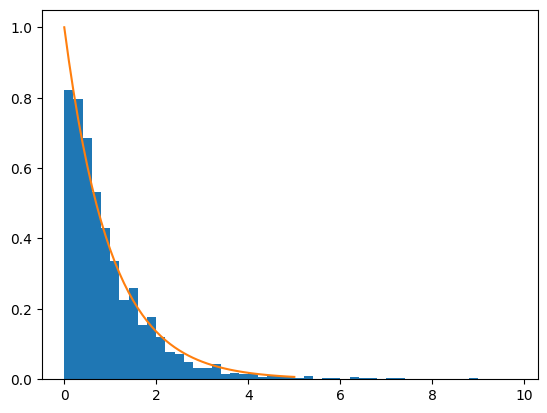

In [19]:
dados = durations2/np.mean(durations2)
plt.hist(dados, bins=[item/5 for item in range(5*10)], density=True)
plt.plot([item/10 for item in range(51)], np.exp(-np.array([item/10 for item in range(51)])))
plt.show()

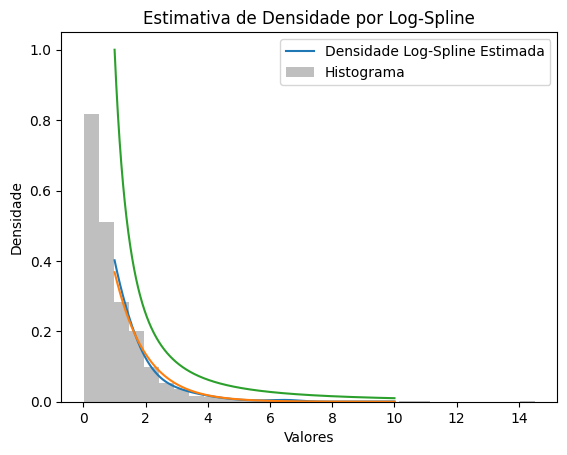

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

dados = durations2/np.mean(durations2)
# 1. Gerar dados aleatórios
# dados = np.random.normal(0, 1, size=1000)

# 2. Definir nós para as splines cúbicas (os pontos onde as splines se conectam)
knots = np.linspace(min(dados), max(dados), 15)  # 10 nós uniformemente espaçados

# 3. Calcular a contagem de dados em torno de cada nó (histograma simples para guiar o ajuste)
hist, edges = np.histogram(dados, bins=knots, density=True)

# 4. Definir as posições médias dos intervalos do histograma como os pontos de ajuste
centros = (edges[:-1] + edges[1:]) / 2

# 5. Ajustar uma spline cúbica aos logaritmos das densidades estimadas (para garantir positividade)
log_densidades = np.log(hist + 1e-9)  # Adiciona um pequeno valor para evitar log(0)

# Ajuste de uma spline cúbica nos pontos médios
spline = CubicSpline(centros, log_densidades, bc_type='natural')

# 6. Definir uma grade de valores x para avaliar a densidade estimada
# x_grid = np.linspace(min(dados), max(dados), 1000)
x_grid = np.linspace(1, 10, 1000)

# 7. Aplicar a exponencial à spline ajustada para obter a densidade final
densidade_estimada = np.exp(spline(x_grid))

# 8. Plotar os resultados
plt.plot(x_grid, densidade_estimada, label='Densidade Log-Spline Estimada')
plt.hist(dados, bins=30, density=True, alpha=0.5, color='gray', label='Histograma')
plt.plot(x_grid, np.exp(-x_grid))
plt.plot(x_grid, 1.0 / (x_grid ** 2))
plt.title("Estimativa de Densidade por Log-Spline")
plt.xlabel("Valores")
plt.ylabel("Densidade")
plt.legend()
plt.show()

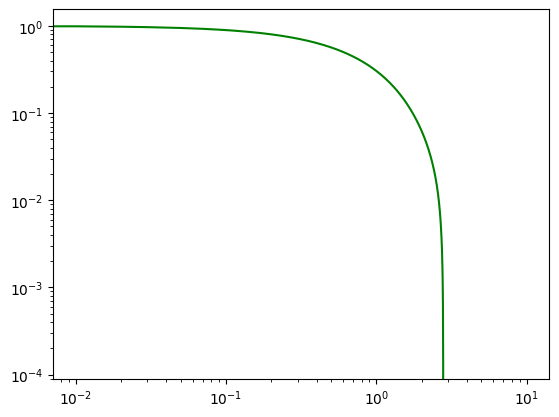

In [55]:
from scipy.integrate import cumulative_trapezoid
cdf_estimada = cumulative_trapezoid(densidade_estimada, x_grid, initial=0)
plt.loglog(x_grid, 1-cdf_estimada, label="CDF Estimada", color="green")

C:\Users\ldonaire\AppData\Local\Temp\ipykernel_18512\2035695932.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.loglog(x_grid, 1.0 / (x_grid ** 2), label="EXP", color="blue")


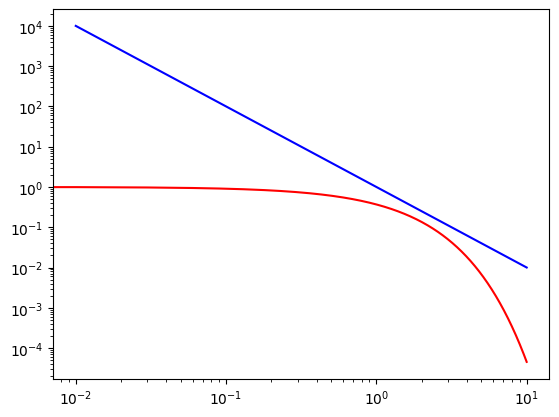

In [3]:
# plt.gca().set_aspect('equal', adjustable='box')
# plt.loglog(x_grid, densidade_estimada, label="Dens Estimada", color="green")
x_grid = np.linspace(0, 10, 1000)
plt.loglog(x_grid, np.exp(-x_grid), label="EXP", color="red")
plt.loglog(x_grid, 1.0 / (x_grid ** 2), label="EXP", color="blue")

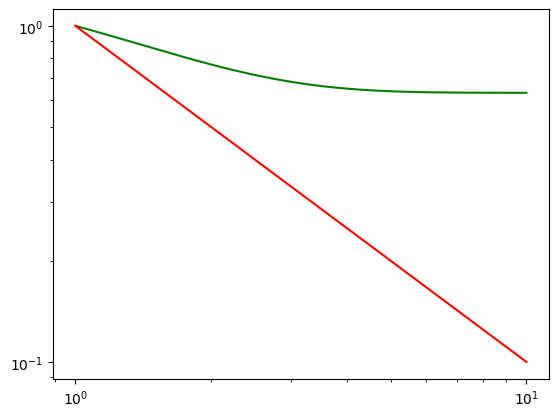

In [29]:
from scipy.integrate import cumulative_trapezoid
cdf_estimada = cumulative_trapezoid(np.exp(-x_grid), x_grid, initial=0)
cdf_estimada2 = cumulative_trapezoid( 1.0 / (x_grid ** 2), x_grid, initial=0)
plt.loglog(x_grid, 1-cdf_estimada, label="CDF Estimada", color="green")
plt.loglog(x_grid, 1-cdf_estimada2, label="CDF Estimada", color="red")

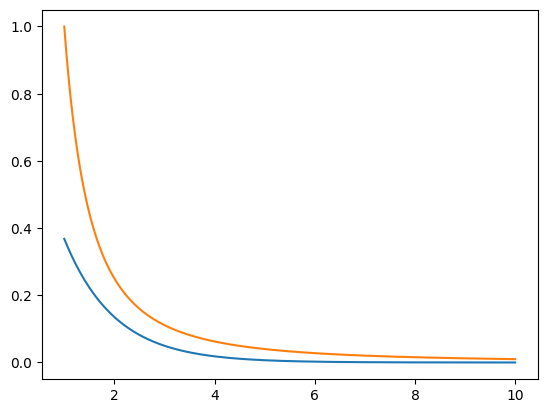

In [32]:
plt.plot(x_grid, np.exp(-x_grid))
plt.plot(x_grid,  1.0 / (x_grid ** 2))

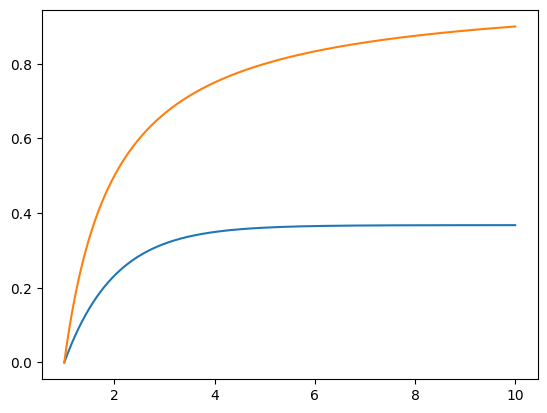

In [33]:
plt.plot(x_grid, cdf_estimada)
plt.plot(x_grid, cdf_estimada2)

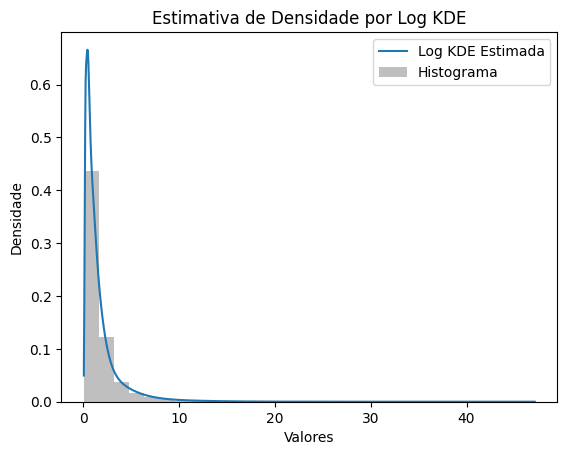

In [67]:
from scipy.stats import gaussian_kde

# 1. Gerar dados de exemplo (distribuição log-normal)
np.random.seed(42)
dados = np.random.lognormal(mean=0, sigma=1, size=1000)  # Dados log-normais

# 2. Aplicar a transformação logarítmica nos dados
dados_log = np.log(dados)

# 3. Estimar a densidade com KDE nos dados log-transformados
kde_log = gaussian_kde(dados_log, bw_method='scott')  # Usar banda "Scott" para suavização

# 4. Criar uma grade de valores no espaço original para avaliação da densidade
x_grid = np.linspace(min(dados), max(dados), 1000)

# 5. Reverter a densidade estimada para o espaço original
# Precisamos calcular a densidade no espaço log-transformado e aplicar a correção da transformação
log_grid = np.log(x_grid)
densidade_log = kde_log(log_grid)  # KDE no espaço log-transformado
densidade = densidade_log / x_grid  # Corrigir pela transformação (Jacobian)

# 6. Plotar a densidade estimada
plt.plot(x_grid, densidade, label='Log KDE Estimada')
plt.hist(dados, bins=30, density=True, alpha=0.5, color='gray', label='Histograma')
plt.xlabel('Valores')
plt.ylabel('Densidade')
plt.title('Estimativa de Densidade por Log KDE')
plt.legend()
plt.show()

In [ ]:
def get_dfprob(dados,passo=None):
    if pd.isnull(passo):
        passo = (max(dados)-min(dados))/50
    bins = np.arange(min(dados), max(dados) + passo, passo)
    bins_discretizados = np.digitize(dados, bins)
    # Calculando a função de probabilidade P(X=x)
    valores_discretizados, contagem = np.unique(bins_discretizados, return_counts=True)
    probabilidade_empirica = contagem / len(dados)
    # Criando um DataFrame para organizar os resultados
    df_probabilidade = pd.DataFrame({
        'Bin': bins[valores_discretizados - 1],
        'P(X=x)': probabilidade_empirica
    })
    # Calculando a função de distribuição acumulada P(X>=x)
    df_probabilidade['P(X>=x)'] = df_probabilidade['P(X=x)'][::-1].cumsum()[::-1]
    return df_probabilidade, bins, valores_discretizados


In [22]:
# dados = [1,2,3,4,5,6,7,8,9,10,11]
dados = sizes097/np.mean(sizes097)
passo=0.3

# bins = np.arange(min(dados), max(dados) + passo, passo)
log_dados = np.log(dados)
bins = np.exp(np.arange(min(log_dados), max(log_dados) + passo, passo))
print(bins)
bins_discretizados = np.digitize(dados, bins) # i: indice do bin no qual dado[i] pertence

print(bins_discretizados)
valores_discretizados, contagem = np.unique(bins_discretizados, return_counts=True)
print(contagem)
print(valores_discretizados)

[7.60054081e-05 1.02596570e-04 1.38490883e-04 1.86943138e-04
 2.52346842e-04 3.40632607e-04 4.59805924e-04 6.20673077e-04
 8.37821019e-04 1.13094008e-03 1.52660943e-03 2.06070719e-03
 2.78166374e-03 3.75485330e-03 5.06852180e-03 6.84178880e-03
 9.23544887e-03 1.24665520e-02 1.68280850e-02 2.27155388e-02
 3.06627701e-02 4.13904103e-02 5.58712098e-02 7.54182447e-02
 1.01803982e-01 1.37421002e-01 1.85498949e-01 2.50397390e-01
 3.38001123e-01 4.56253793e-01 6.15878201e-01 8.31348614e-01
 1.12220325e+00 1.51481594e+00 2.04478764e+00 2.76017460e+00
 3.72584600e+00 5.02936603e+00 6.78893404e+00 9.16410240e+00]
[18 36 33 ... 24 34 26]
[  2   3   4   6  13   9   3   2   4   2   1   2   7   6  12  17  15  24
  40  46  63  90  94 117 148 210 199 208 205 175 145  72  47   8   1]
[ 1  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39]


# Estimar densidade

In [40]:
[sizes1,durations1,sizes097,durations097] = read_pkl("Sizes_Durations_2000Trials_WUnif_alpha1_and_alpha097_phi_Vmax0_14p715")

In [81]:
sizes097 = [1+item for item in sizes097]

In [82]:
# dados = sizes097/np.mean(sizes097)
dados = durations097/np.mean(durations097)

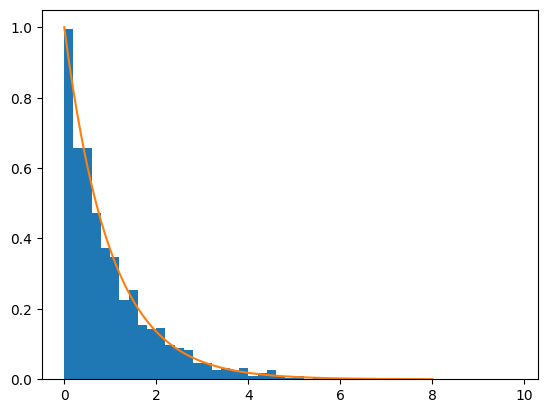

In [65]:
x_grid = np.linspace(0, 8, 1000)
plt.hist(dados, bins=[item/5 for item in range(5*10)], density=True)
plt.plot(x_grid, np.exp(-x_grid))
plt.show()

In [91]:
from scipy.stats import gaussian_kde
from scipy.interpolate import CubicSpline

# x_grid = np.linspace(0, 8, 1000)
x_grid = np.linspace(min(dados), max(dados), 100)  # Criar uma grade para plotar

# plt.hist(dados, bins=30, density=True, alpha=0.5, color='gray', label='Histograma')
# plt.plot(x_grid, np.exp(-x_grid))


kde = gaussian_kde(dados)
densidade_kde = kde(x_grid)
# plt.plot(x_grid, densidade_kde, label='KDE')


# dados_log = np.log(dados)
# kde_log = gaussian_kde(dados_log)
# x_grid_log = np.linspace(np.log(min(dados)), np.log(max(dados)), 1000)
# densidade_log = kde_log(x_grid_log)
# densidade_log_kde = densidade_log / np.exp(x_grid_log)
# plt.plot(np.exp(x_grid_log), densidade_log_kde, label='Log-KDE')

kde_log = gaussian_kde(dados_log, bw_method='scott')  # Usar banda "Scott" para suavização
log_grid = np.log(x_grid)
densidade_log = kde_log(log_grid)  # KDE no espaço log-transformado
densidade = densidade_log / x_grid  # Corrigir pela transformação (Jacobian)
# plt.plot(x_grid, densidade, label='Spline')



knots = np.linspace(min(dados), max(dados), 10)  
hist, edges = np.histogram(dados, bins=knots, density=True)
centros = (edges[:-1] + edges[1:]) / 2
log_densidades = np.log(hist + 1e-9) 
spline = CubicSpline(centros, log_densidades, bc_type='natural')
densidade_estimada = np.exp(spline(x_grid))
# plt.plot(x_grid, densidade_estimada, label='Spline')

 

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=dados,
    histnorm='probability density',  # Normalizar o histograma para probabilidades
    xbins=dict(start=0, end=10, size=0.1),
    marker=dict(color='lightblue'),
    name='Histograma'
))
fig.add_trace(go.Scatter(
    x=x_grid,  
    y=np.exp(-x_grid),  
    name='Exponencial'
))
fig.add_trace(go.Scatter(
    x=x_grid,  
    y=densidade_kde,  
    name='KDE'
))
fig.add_trace(go.Scatter(
    x=x_grid,  
    y=densidade,  
    name='Log-KDE'
))
fig.add_trace(go.Scatter(
    x=x_grid,  
    y=densidade_estimada,  
    name='Spline'
))


fig.update_layout(
    width=1200,  # Largura da figura
    height=800   # Altura da figura
)



fig.show()